In [1]:
import numpy as np
import pandas as pd
import time, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [2]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, adjusted_mutual_info_score
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
import tcremb.ml_utils as ml_utils
import benchmark.models as models
import benchmark.metrics as metrics
import tcremb.TCRemb as TCRemb
from sklearn.cluster import KMeans,DBSCAN

In [4]:
label = 'antigen.epitope'
label_s = 'antigen.species'
#label = 'antigen.species_freq'
#output_suf = 'vdjdb_freq'
#output_suf = 'vdjdb'
#output_suf_s = 'vdjdb_s'

## Run with different protototypes

In [15]:
#samples_n = [1000]
samples_n = [10,50,100,500,1000]
prototypes_n = [100, 150, 300, 500, 1000,2000,3000, 5000]
#prototypes_n = [100]

In [16]:
def run_tcremb_v(run_name, v_path, proto_path):
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    tcremb = TCRemb.TCRemb(run_name, vdjdb_v,prototypes_path=proto_path_dict)
    tcremb.tcremb_clonotypes('TRA')
    tcremb.tcremb_clonotypes('TRB')
    tcremb.tcremb_clonotypes('TRA_TRB')
    tcremb.tcremb_dists_count('TRA')
    tcremb.tcremb_dists_count('TRB')
    tcremb.tcremb_dists_count('TRA_TRB')
    tcremb.tcremb_dists('TRA')
    tcremb.tcremb_dists('TRB')
    tcremb.tcremb_dists('TRA_TRB')
    

In [ ]:
for i in samples_n:
    for j in prototypes_n:
        run_name = f'compare_V{i}_{j}'
        if j==3000:
            proto_path_dict = {'TRA' :f'data/data_preped/olga_humanTRA.txt', 'TRB' : f'data/data_preped/olga_humanTRB.txt'}
        else:
            proto_path_dict = {'TRA' :f'data/data_preped/olga_humanTRA_{j}.txt', 'TRB' : f'data/data_preped/olga_humanTRB_{j}.txt'}
    
        v_path = f'data/data_preped/VDJdb_data_V{i}.csv'
        run_tcremb_v(run_name, v_path, proto_path_dict)

## Compare clustering

In [5]:
samples_n = [10,50,100,500,1000]
#samples_n = [500,1000]

In [6]:
metrics_tcremb = {}

### dbscan eps

In [7]:
method = 'dbscan'
metrics_tcremb[method]={}
params=[3, 10,25, 50,75, 100,150,200,250,300,350,400,450, 500,550, 600,650, 700,750, 800,850, 900,950, 1000, 1050,1100,1150, 1200,1250, 1300,1350, 1400,1450, 1500]
#params = [3, 1500]

In [ ]:
chain = 'TRA'
metrics_tcremb[method][chain]={}
for i in samples_n:
    run_name = f'compare_V{i}'
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
    tcremb.tcremb_clonotypes(chain)
    tcremb.tcremb_dists(chain)
    tcremb.tcremb_pca(chain)
    tcremb.tcremb_tsne(chain)
    
    for j in params:
        dbscan = TCRemb.TCRemb_clustering(method)
        model = DBSCAN(eps=j, min_samples=2)
        dbscan.clstr(chain,tcremb, label, model=model)
        t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
        metrics_tcremb[method][chain][f'{i}_{j}'] = metrics.get_clustermetrics(t, label)
        metrics_tcremb[method][chain][f'{i}_{j}']['eps']=j
        metrics_tcremb[method][chain][f'{i}_{j}']['v']=f'V{i} dataset size:{len(tcremb.pca_clones[chain])}'

In [ ]:
chain = 'TRB'
metrics_tcremb[method][chain]={}
for i in samples_n:
    run_name = f'compare_V{i}'
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
    tcremb.tcremb_clonotypes(chain)
    tcremb.tcremb_dists(chain)
    tcremb.tcremb_pca(chain)
    tcremb.tcremb_tsne(chain)
    
    for j in params:
        dbscan = TCRemb.TCRemb_clustering(method)
        model = DBSCAN(eps=j, min_samples=2)
        dbscan.clstr(chain,tcremb, label, model=model)
        t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
        metrics_tcremb[method][chain][f'{i}_{j}'] = metrics.get_clustermetrics(t, label)
        metrics_tcremb[method][chain][f'{i}_{j}']['eps']=j
        metrics_tcremb[method][chain][f'{i}_{j}']['v']=f'V{i} dataset size:{len(tcremb.pca_clones[chain])}'

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


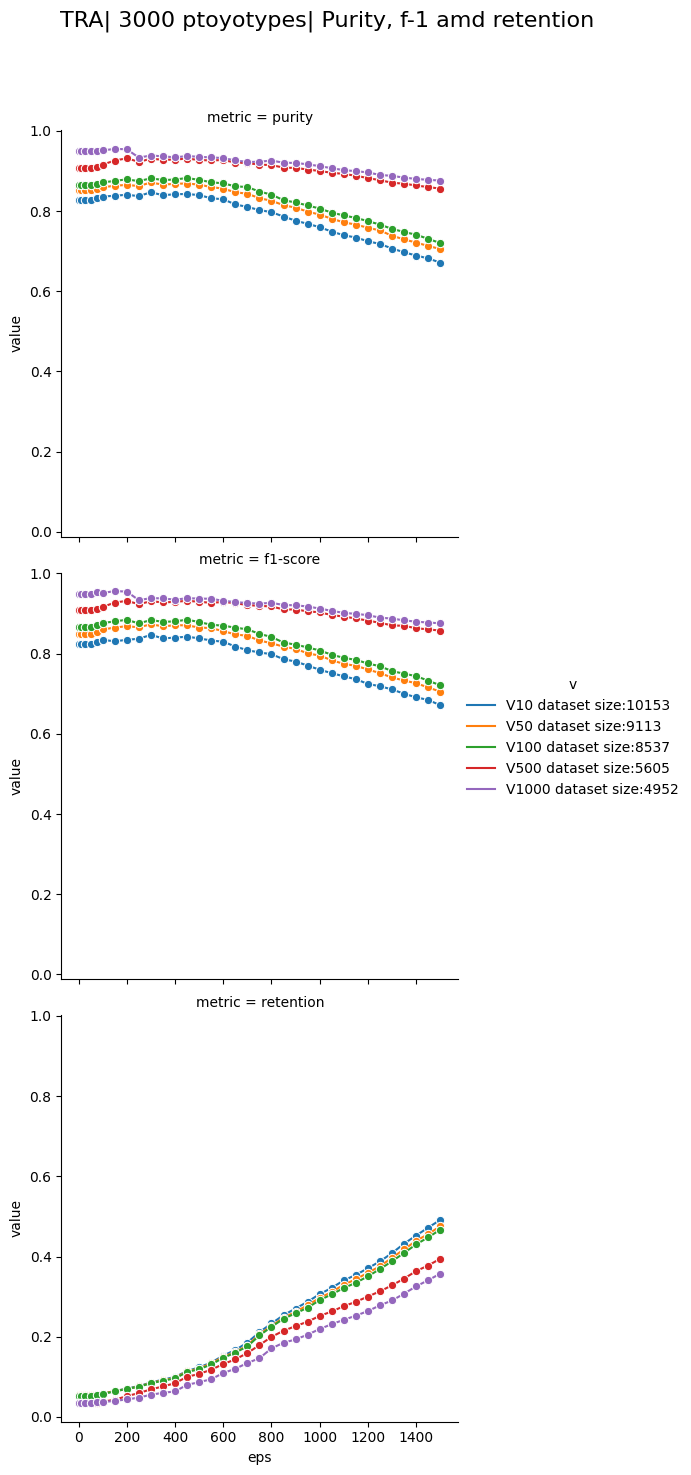

In [11]:
chain = 'TRA'
n_prototypes = 3000
method = 'dbscan'
metrics_df = pd.DataFrame(metrics_tcremb[method][chain]).T
t = metrics_df[['purity','f1-score','retention','eps','v']].melt(id_vars=['eps','v'],var_name='metric')
g = sns.relplot(data = t, x = 'eps', y = 'value', hue='v', row='metric',kind="line",marker='o')
g.fig.suptitle(f'{chain}| {n_prototypes} ptoyotypes| Purity, f-1 amd retention', fontsize=16)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig(f"figures/tcremb_compare_{method}_{chain}.png")

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


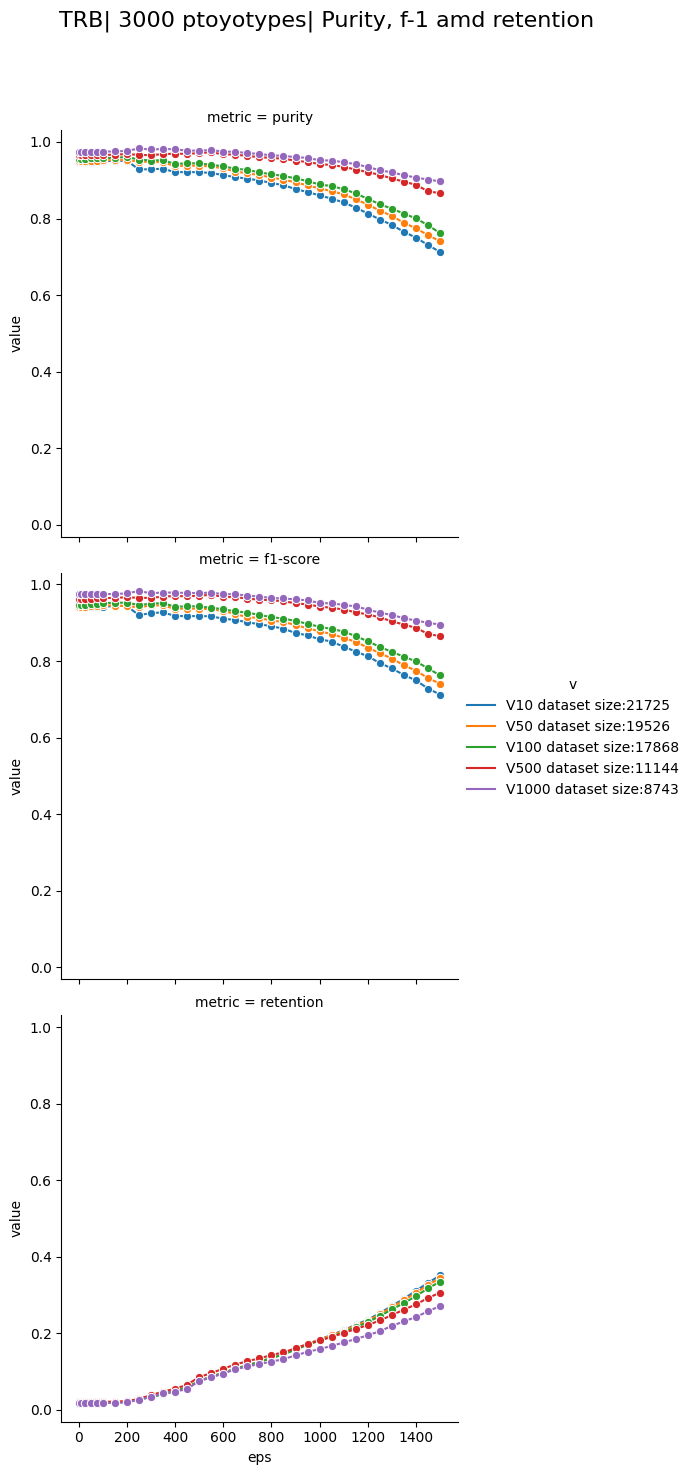

In [18]:
chain = 'TRB'
n_prototypes = 3000
method = 'dbscan'
metrics_df = pd.DataFrame(metrics_tcremb[method][chain]).T
t = metrics_df[['purity','f1-score','retention','eps','v']].melt(id_vars=['eps','v'],var_name='metric')
g = sns.relplot(data = t, x = 'eps', y = 'value', hue='v', row='metric',kind="line",marker='o')
g.fig.suptitle(f'{chain}| {n_prototypes} ptoyotypes| Purity, f-1 amd retention', fontsize=16)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig(f"figures/tcremb_compare_{method}_{chain}.png")

### Kmeans n_clusters

In [13]:
method = 'kmeans'
metrics_tcremb[method]={}

In [ ]:
chain = 'TRA'
metrics_tcremb[method][chain]={}
for i in samples_n:
    run_name = f'compare_V{i}'
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
    tcremb.tcremb_clonotypes(chain)
    tcremb.tcremb_dists(chain)
    tcremb.tcremb_pca(chain)
    tcremb.tcremb_tsne(chain)
    
    data_len = len(tcremb.pca_clones[chain])
    
    range_n_clusters = [round(data_len*0.005),round(data_len*0.01), round(data_len*0.05) , round(data_len*0.1), round(data_len*0.15)                    
                        ,round(data_len*0.2), round(data_len*0.25), round(data_len*0.3)
                        , round(data_len*0.4), round(data_len*0.5), round(data_len*0.6), round(data_len*0.7), round(data_len*0.8), round(data_len*0.9)]
    
    for j in range_n_clusters:
        dbscan = TCRemb.TCRemb_clustering(method)
        model = KMeans(n_clusters=j)
        dbscan.clstr(chain,tcremb, label, model=model)
        t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
        metrics_tcremb[method][chain][f'{i}_{j}'] = metrics.get_clustermetrics(t, label)
        metrics_tcremb[method][chain][f'{i}_{j}']['n_clusters']=j
        metrics_tcremb[method][chain][f'{i}_{j}']['v']=f'V{i} dataset size:{len(tcremb.pca_clones[chain])}'

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


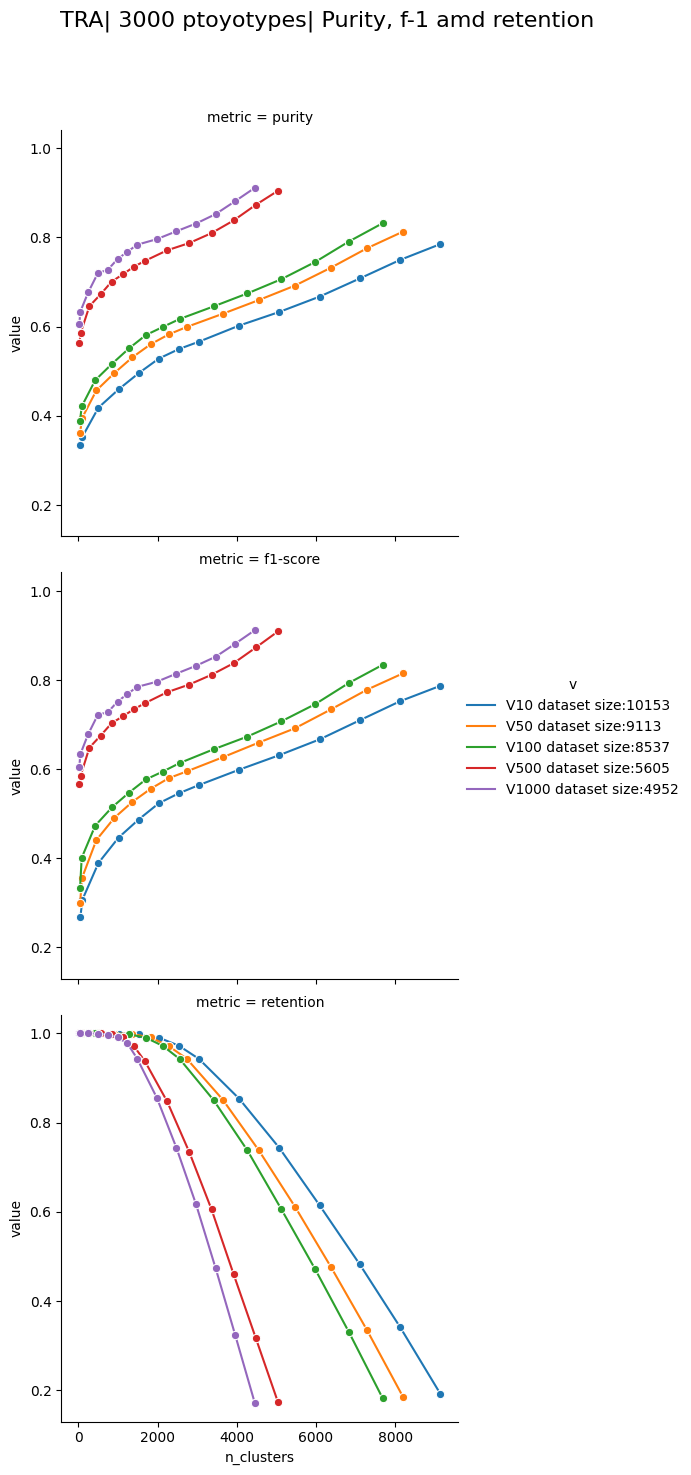

In [15]:
chain = 'TRA'
n_prototypes=3000
method = 'kmeans'
metrics_df = pd.DataFrame(metrics_tcremb[method][chain]).T
t = metrics_df[['purity','f1-score','retention','n_clusters','v']].melt(id_vars=['n_clusters','v'],var_name='metric')
g = sns.relplot(data = t, x = 'n_clusters', y = 'value', hue='v', row='metric',kind="line",marker='o')
g.fig.suptitle(f'{chain}| {n_prototypes} ptoyotypes| Purity, f-1 amd retention', fontsize=16)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig(f"figures/tcremb_compare_{n_prototypes}_{method}_{chain}.png")

In [ ]:
chain = 'TRB'
metrics_tcremb[method][chain]={}
for i in samples_n:
    run_name = f'compare_V{i}'
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
    tcremb.tcremb_clonotypes(chain)
    tcremb.tcremb_dists(chain)
    tcremb.tcremb_pca(chain)
    tcremb.tcremb_tsne(chain)
    
    data_len = len(tcremb.pca_clones[chain])
    
    range_n_clusters = [round(data_len*0.005),round(data_len*0.01), round(data_len*0.05) , round(data_len*0.1), round(data_len*0.15)                    
                        ,round(data_len*0.2), round(data_len*0.25), round(data_len*0.3)
                        , round(data_len*0.4), round(data_len*0.5), round(data_len*0.6), round(data_len*0.7), round(data_len*0.8), round(data_len*0.9)]
    
    for j in range_n_clusters:
        dbscan = TCRemb.TCRemb_clustering(method)
        model = KMeans(n_clusters=j)
        dbscan.clstr(chain,tcremb, label, model=model)
        t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
        metrics_tcremb[method][chain][f'{i}_{j}'] = metrics.get_clustermetrics(t, label)
        metrics_tcremb[method][chain][f'{i}_{j}']['n_clusters']=j
        metrics_tcremb[method][chain][f'{i}_{j}']['v']=f'V{i} dataset size:{len(tcremb.pca_clones[chain])}'

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


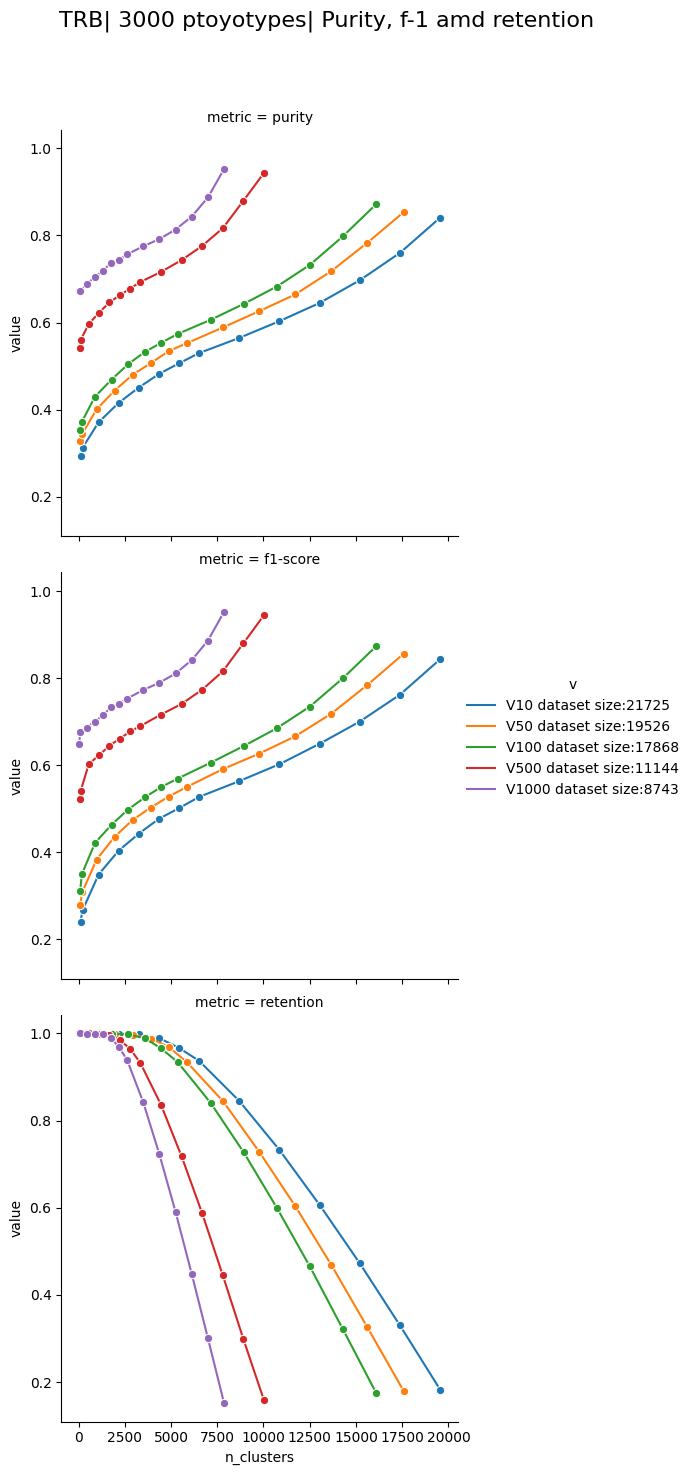

In [17]:
chain = 'TRB'
n_prototypes=3000
method = 'kmeans'
metrics_df = pd.DataFrame(metrics_tcremb[method][chain]).T
t = metrics_df[['purity','f1-score','retention','n_clusters','v']].melt(id_vars=['n_clusters','v'],var_name='metric')
g = sns.relplot(data = t, x = 'n_clusters', y = 'value', hue='v', row='metric',kind="line",marker='o')
g.fig.suptitle(f'{chain}| {n_prototypes} ptoyotypes| Purity, f-1 amd retention', fontsize=16)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig(f"figures/tcremb_compare_{n_prototypes}_{method}_{chain}.png")

In [ ]:
#method = 'kmeans'
#metrics_tcremb[method]={}

In [13]:
n_prototypes = 100
metrics_tcremb[method][n_prototypes]={}

In [ ]:


chain = 'TRA'
metrics_tcremb[method][n_prototypes][chain]={}
for i in samples_n:
    run_name = f'compare_V{i}_{n_prototypes}'
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
    tcremb.tcremb_clonotypes(chain)
    tcremb.tcremb_dists(chain)
    tcremb.tcremb_pca(chain)
    tcremb.tcremb_tsne(chain)
    
    data_len = len(tcremb.pca_clones[chain])
    
    range_n_clusters = [round(data_len*0.005),round(data_len*0.01), round(data_len*0.05) , round(data_len*0.1), round(data_len*0.15)                    
                        ,round(data_len*0.2), round(data_len*0.25), round(data_len*0.3)
                        , round(data_len*0.4), round(data_len*0.5), round(data_len*0.6), round(data_len*0.7), round(data_len*0.8), round(data_len*0.9)]
    
    for j in range_n_clusters:
        dbscan = TCRemb.TCRemb_clustering(method)
        model = KMeans(n_clusters=j)
        dbscan.clstr(chain,tcremb, label, model=model)
        t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}'] = metrics.get_clustermetrics(t, label)
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}']['n_clusters']=j
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}']['v']=f'V{i}_TCRs_count:{len(tcremb.pca_clones[chain])}'

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


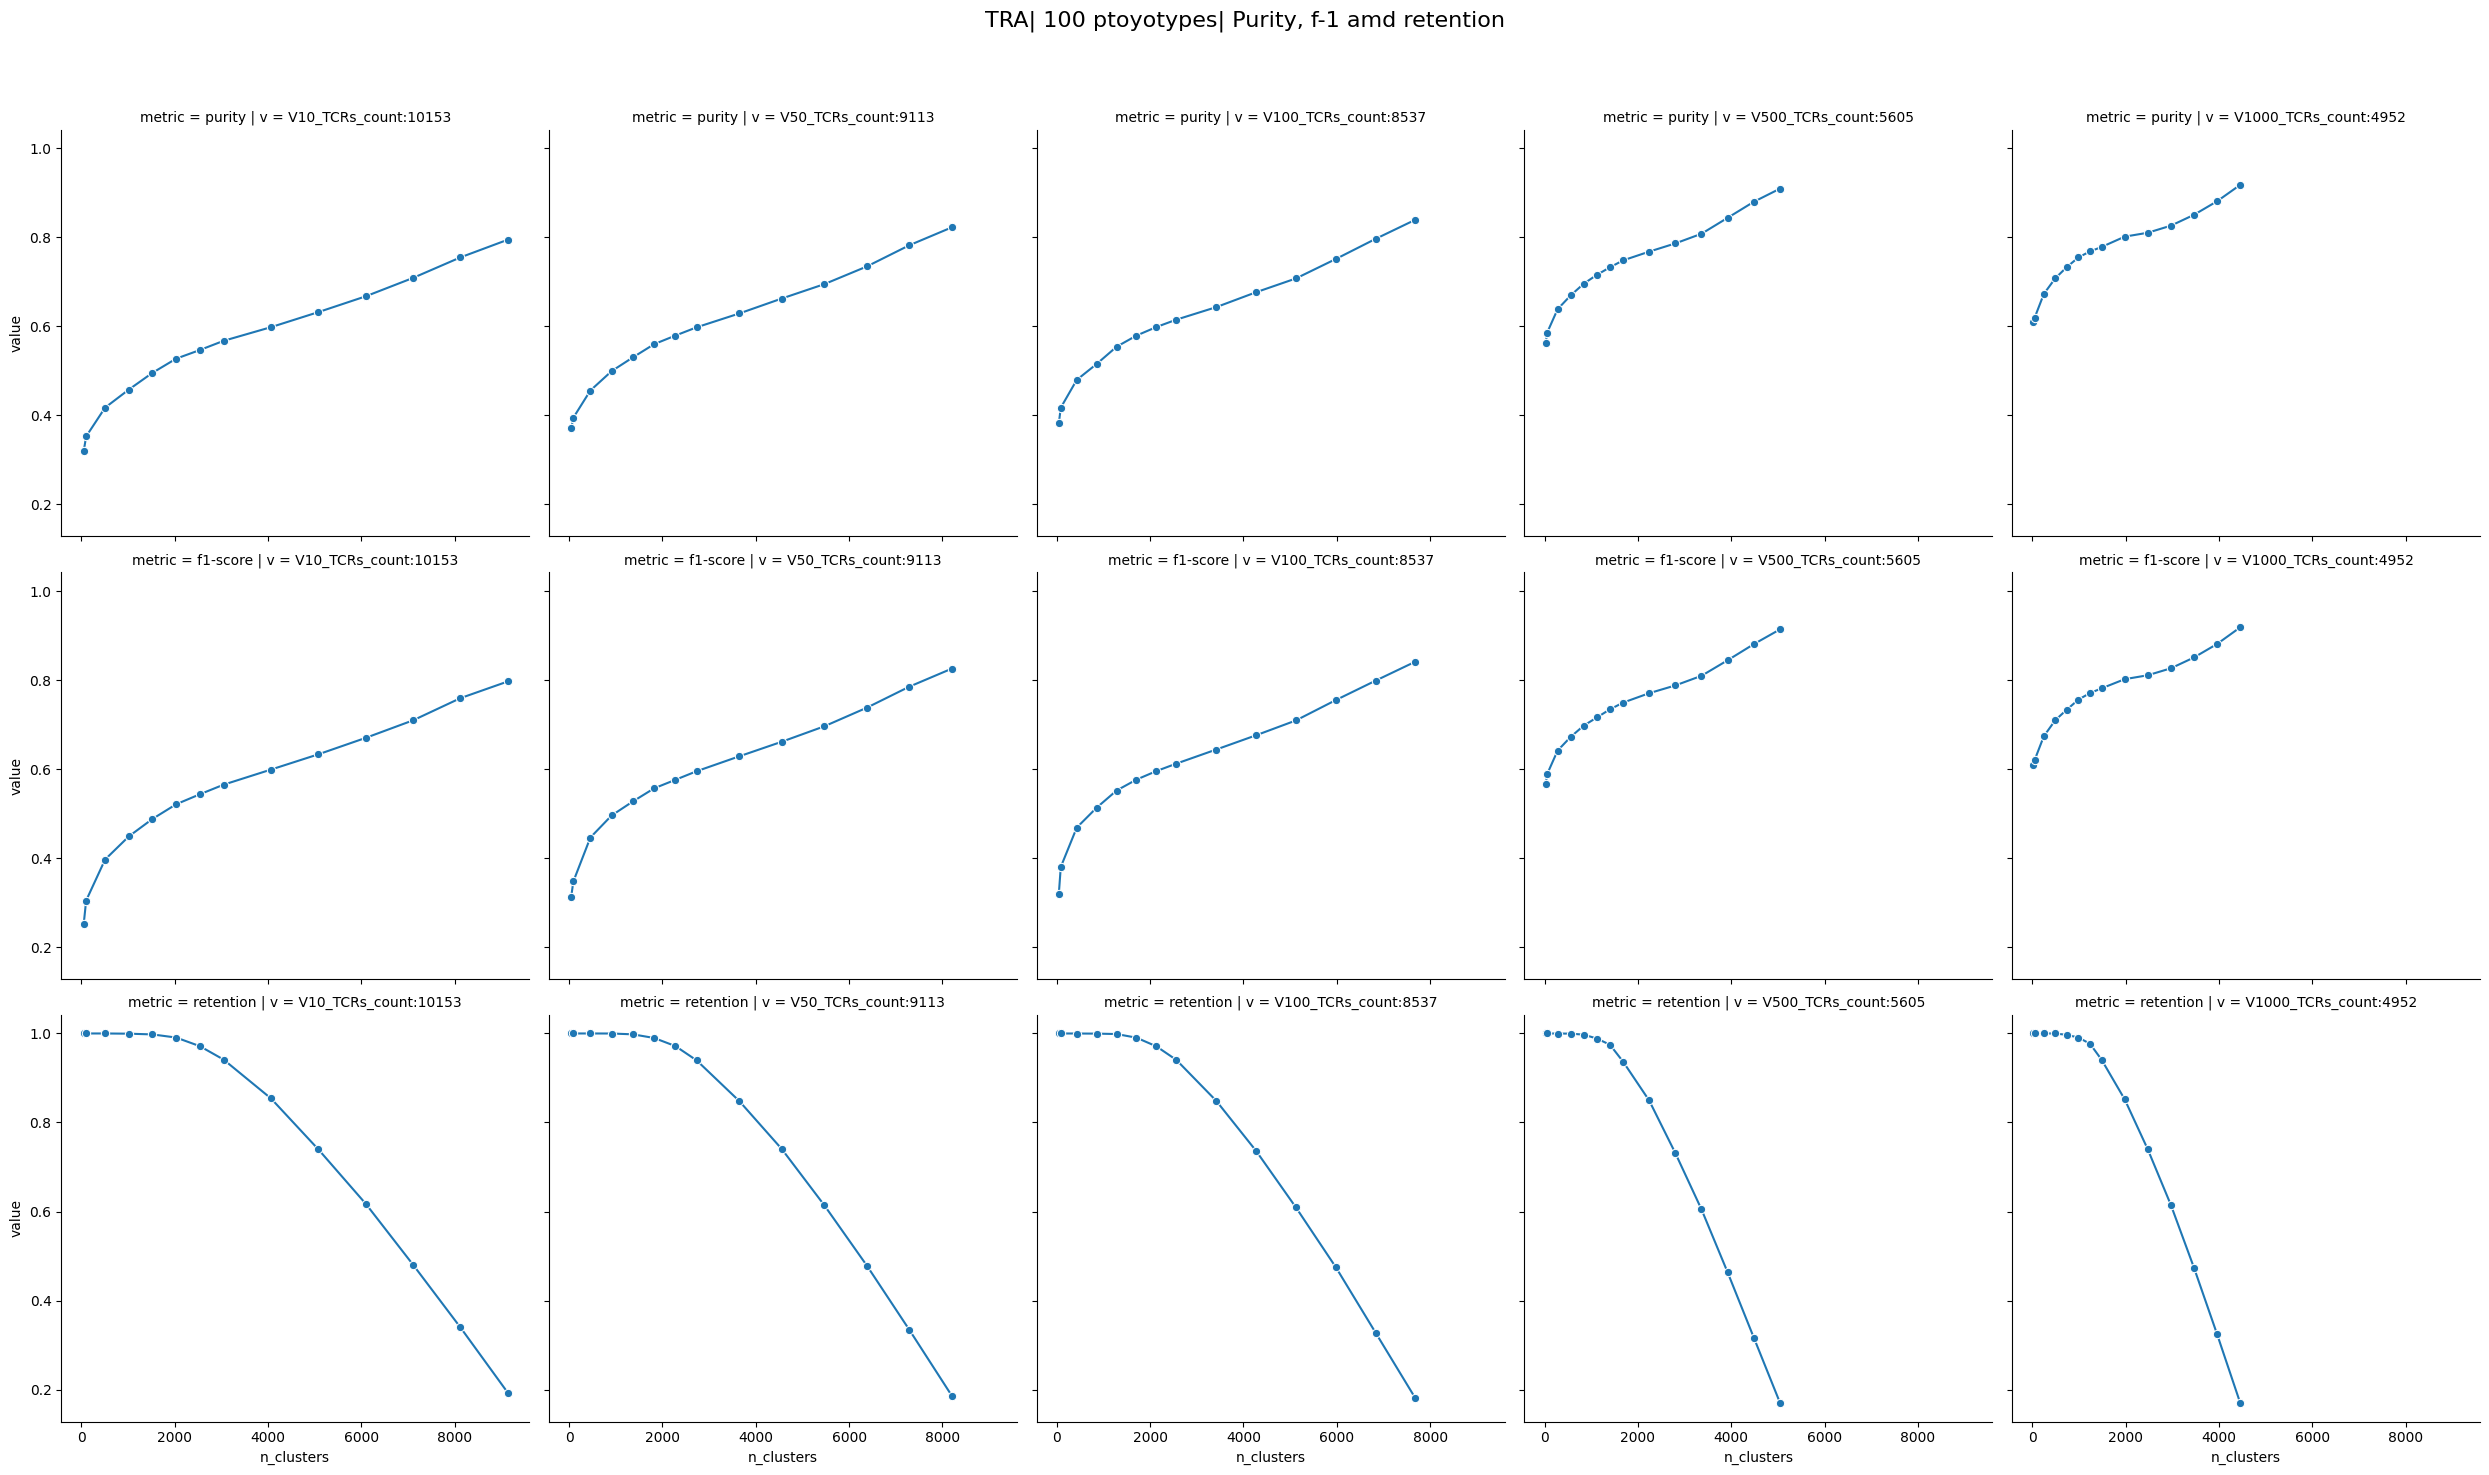

In [15]:
metrics_df = pd.DataFrame(metrics_tcremb[method][n_prototypes][chain]).T
t = metrics_df[['purity','f1-score','retention','n_clusters','v']].melt(id_vars=['n_clusters','v'],var_name='metric')
g = sns.relplot(data = t, x = 'n_clusters', y = 'value', hue='v', row='metric',kind="line",marker='o')
g.fig.suptitle(f'{chain}| {n_prototypes} ptoyotypes| Purity, f-1 amd retention', fontsize=16)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig(f"figures/tcremb_compare_{n_prototypes}_{method}_{chain}.png")

In [ ]:


chain = 'TRB'
metrics_tcremb[method][n_prototypes][chain]={}
for i in samples_n:
    run_name = f'compare_V{i}_{n_prototypes}'
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
    tcremb.tcremb_clonotypes(chain)
    tcremb.tcremb_dists(chain)
    tcremb.tcremb_pca(chain)
    tcremb.tcremb_tsne(chain)
    
    data_len = len(tcremb.pca_clones[chain])
    
    range_n_clusters = [round(data_len*0.005),round(data_len*0.01), round(data_len*0.05) , round(data_len*0.1), round(data_len*0.15)                    
                        ,round(data_len*0.2), round(data_len*0.25), round(data_len*0.3)
                        , round(data_len*0.4), round(data_len*0.5), round(data_len*0.6), round(data_len*0.7), round(data_len*0.8), round(data_len*0.9)]
    
    for j in range_n_clusters:
        dbscan = TCRemb.TCRemb_clustering(method)
        model = KMeans(n_clusters=j)
        dbscan.clstr(chain,tcremb, label, model=model)
        t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}'] = metrics.get_clustermetrics(t, label)
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}']['n_clusters']=j
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}']['v']=f'V{i}_TCRs_count:{len(tcremb.pca_clones[chain])}'

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


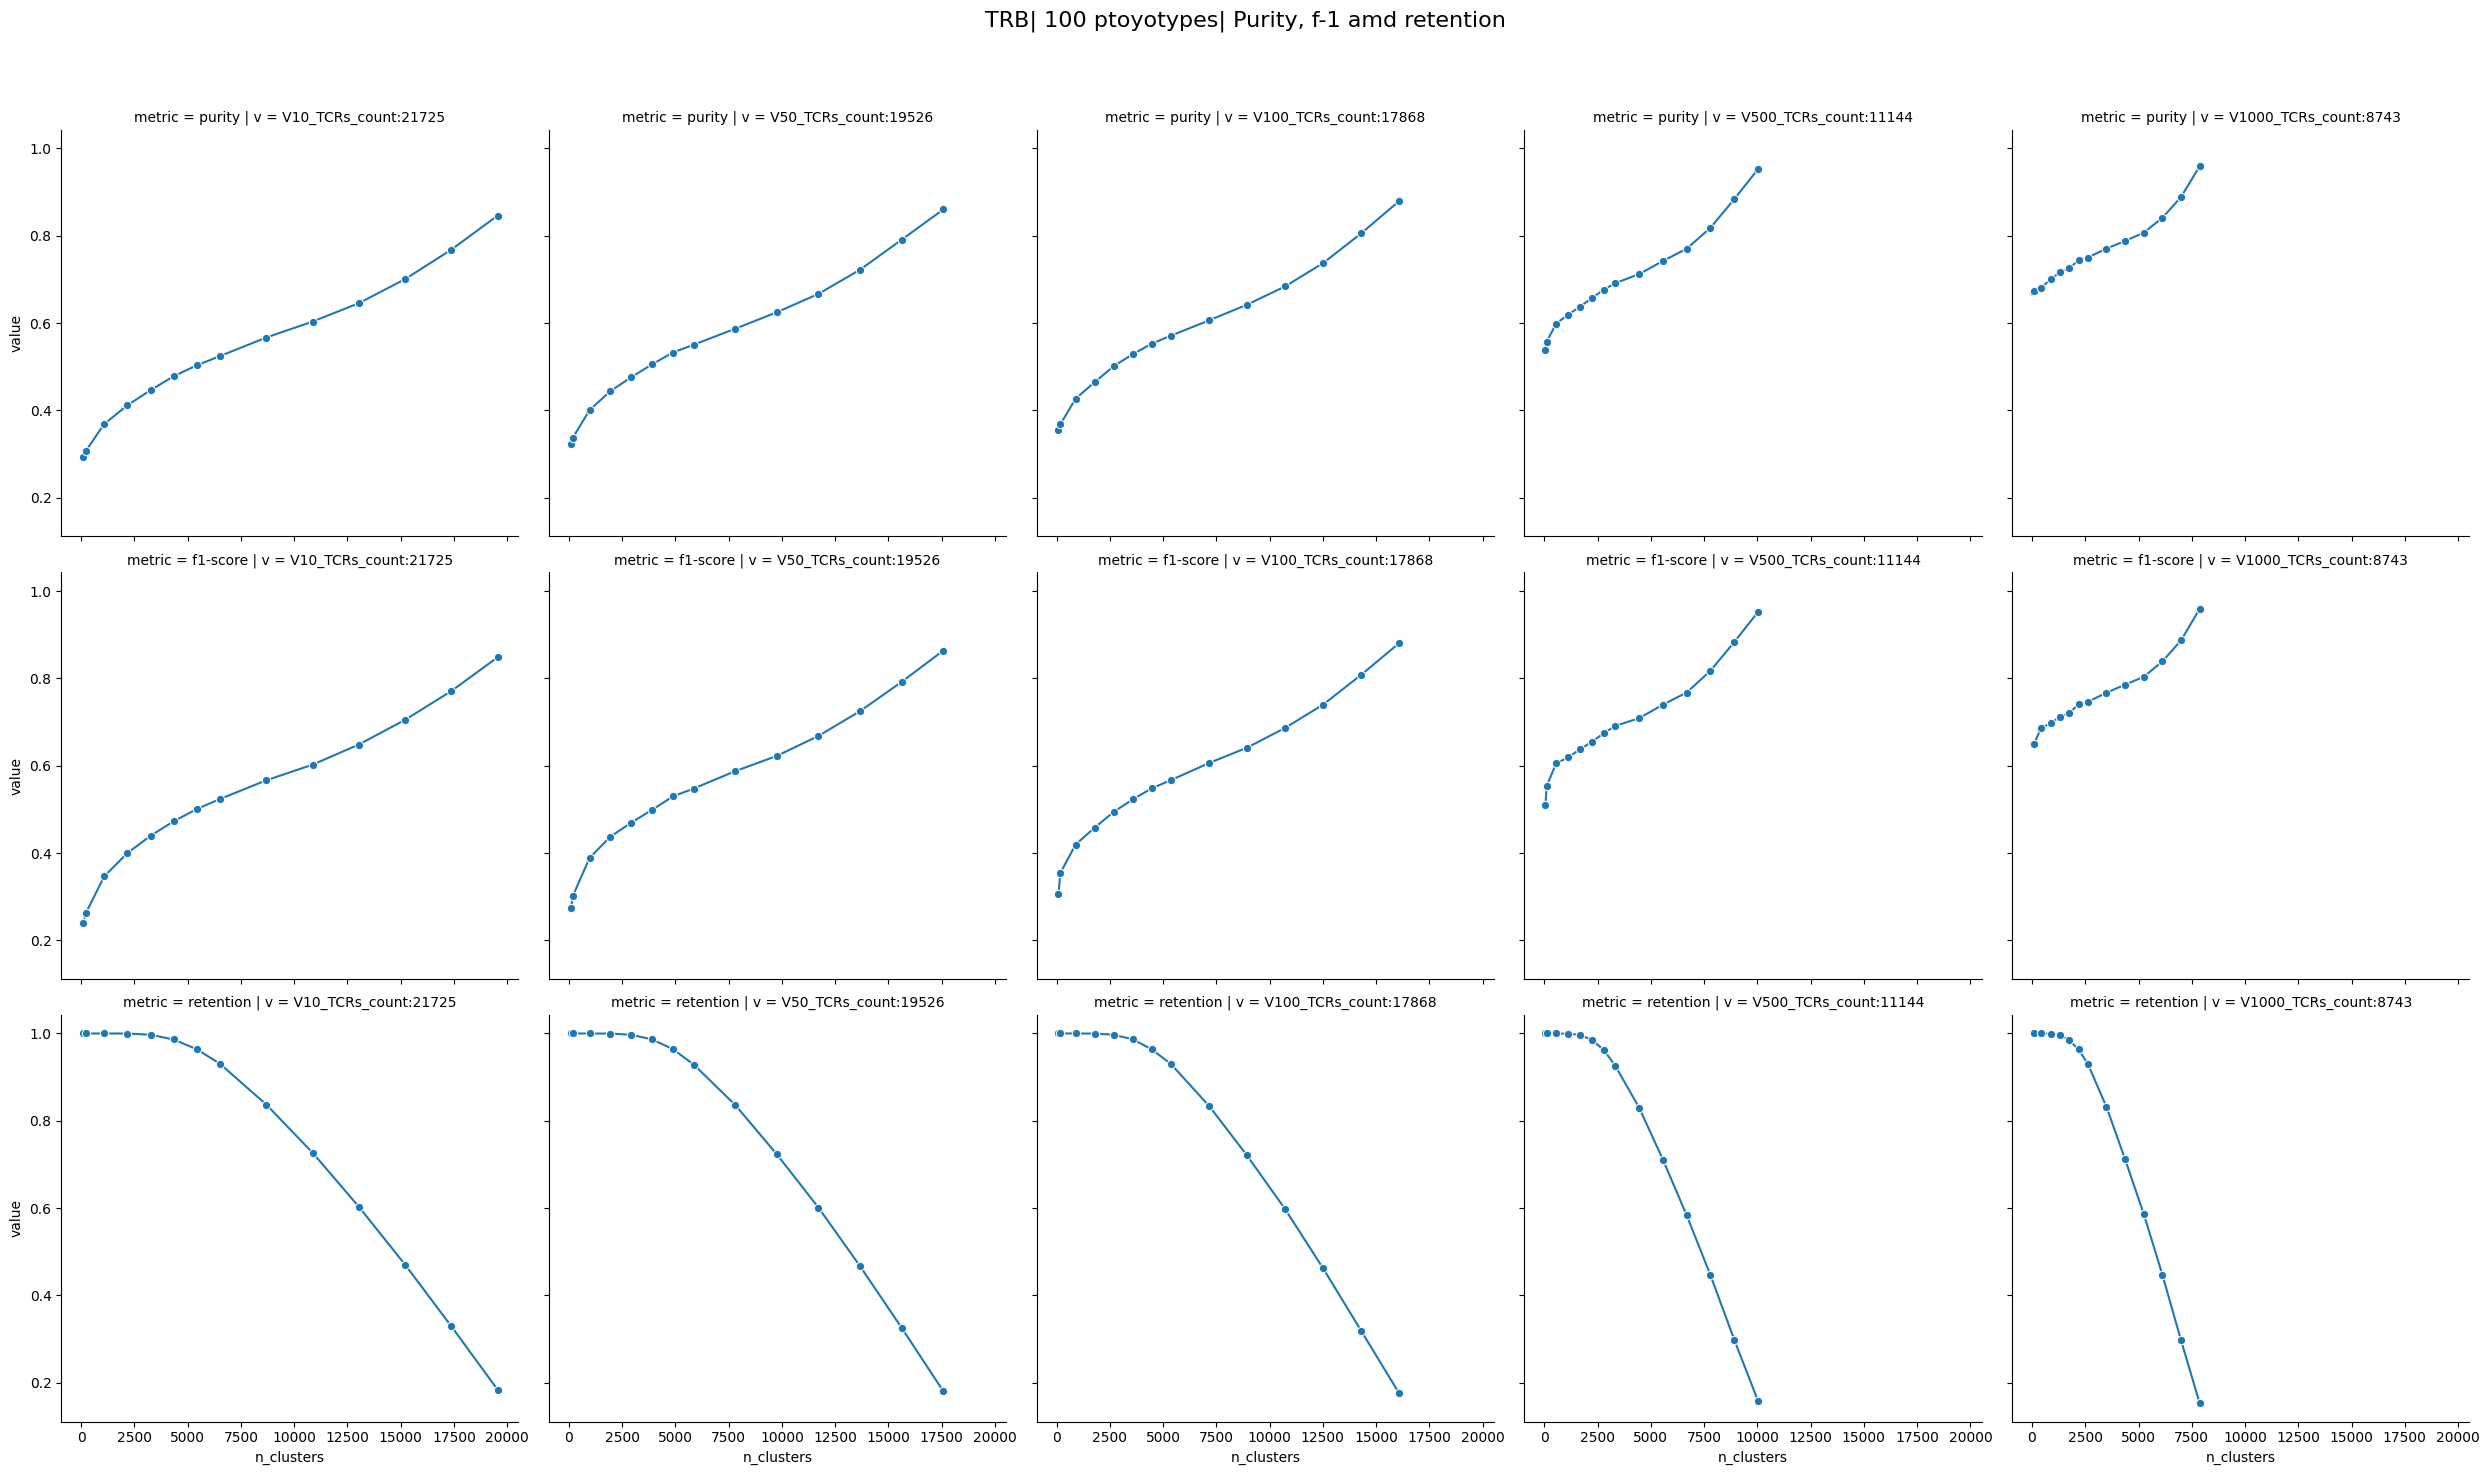

In [17]:
metrics_df = pd.DataFrame(metrics_tcremb[method][n_prototypes][chain]).T
t = metrics_df[['purity','f1-score','retention','n_clusters','v']].melt(id_vars=['n_clusters','v'],var_name='metric')
g = sns.relplot(data = t, x = 'n_clusters', y = 'value', hue='v', row='metric',kind="line",marker='o')
g.fig.suptitle(f'{chain}| {n_prototypes} ptoyotypes| Purity, f-1 amd retention', fontsize=16)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig(f"figures/tcremb_compare_{n_prototypes}_{method}_{chain}.png")

In [18]:
n_prototypes = 1000
metrics_tcremb[method][n_prototypes]={}

In [ ]:


chain = 'TRA'
metrics_tcremb[method][n_prototypes][chain]={}
for i in samples_n:
    run_name = f'compare_V{i}_{n_prototypes}'
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
    tcremb.tcremb_clonotypes(chain)
    tcremb.tcremb_dists(chain)
    tcremb.tcremb_pca(chain)
    tcremb.tcremb_tsne(chain)
    
    data_len = len(tcremb.pca_clones[chain])
    
    range_n_clusters = [round(data_len*0.005),round(data_len*0.01), round(data_len*0.05) , round(data_len*0.1), round(data_len*0.15)                    
                        ,round(data_len*0.2), round(data_len*0.25), round(data_len*0.3)
                        , round(data_len*0.4), round(data_len*0.5), round(data_len*0.6), round(data_len*0.7), round(data_len*0.8), round(data_len*0.9)]
    
    for j in range_n_clusters:
        dbscan = TCRemb.TCRemb_clustering(method)
        model = KMeans(n_clusters=j)
        dbscan.clstr(chain,tcremb, label, model=model)
        t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}'] = metrics.get_clustermetrics(t, label)
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}']['n_clusters']=j
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}']['v']=f'V{i}_TCRs_count:{len(tcremb.pca_clones[chain])}'

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


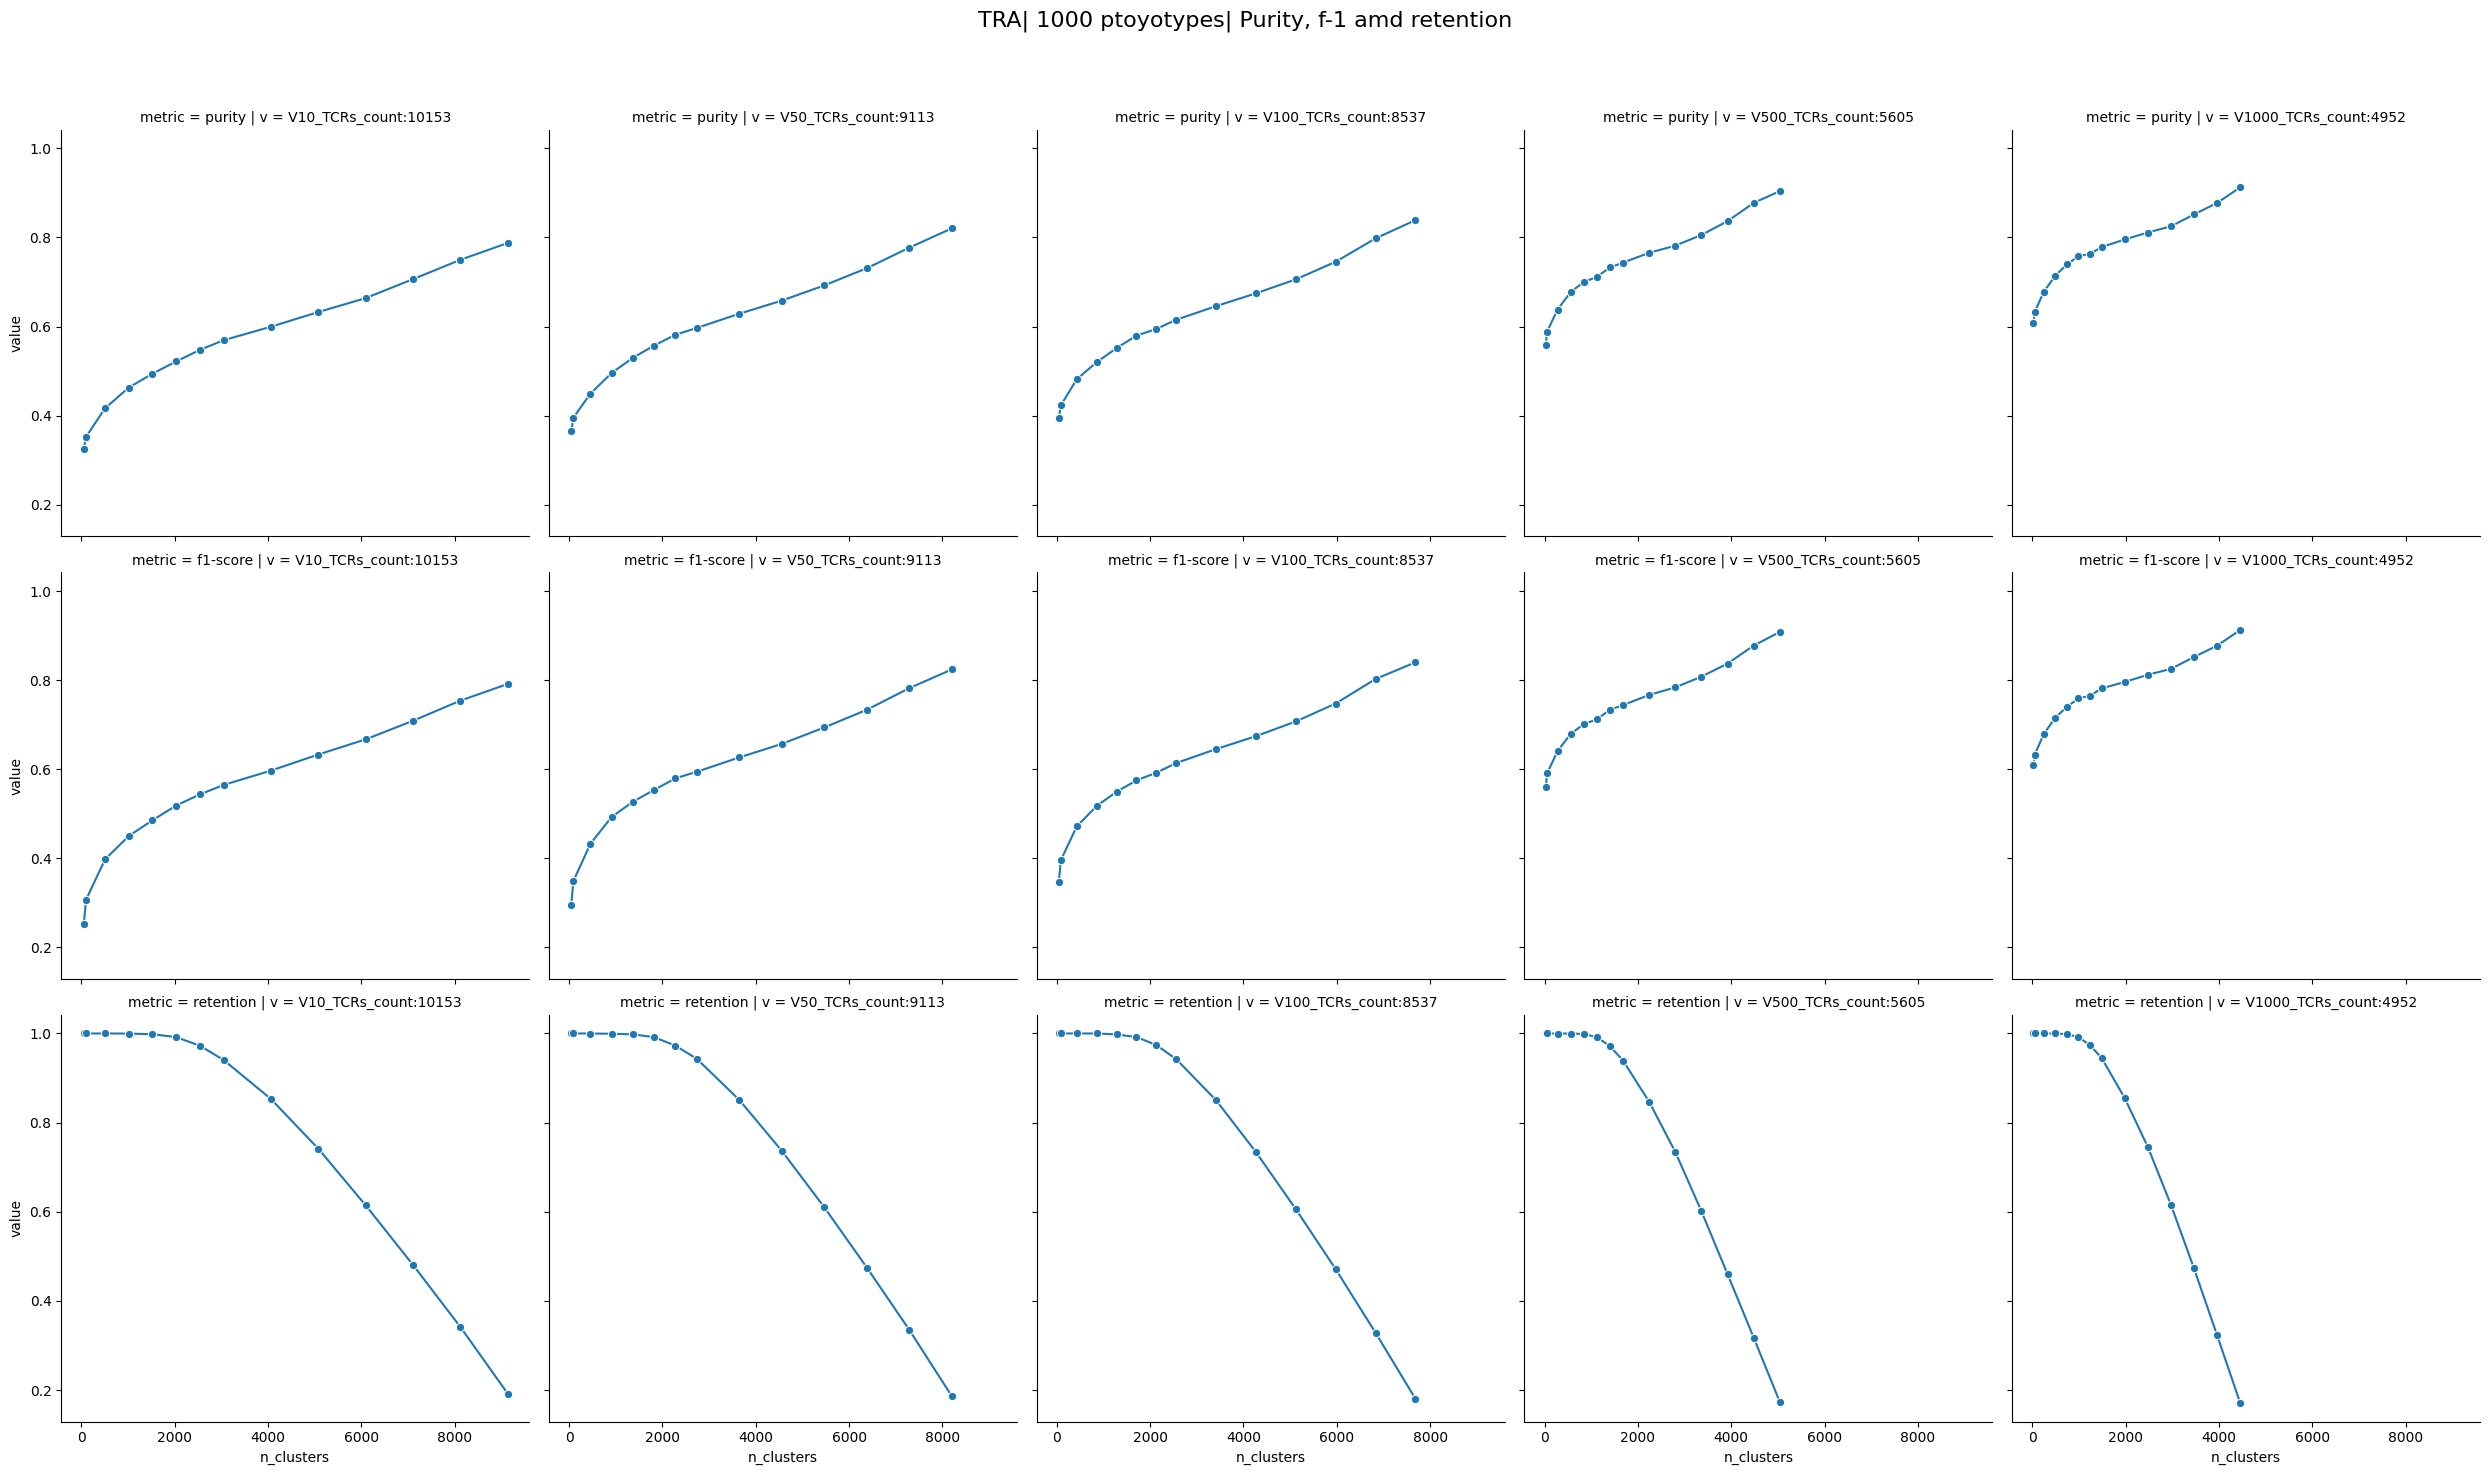

In [20]:
metrics_df = pd.DataFrame(metrics_tcremb[method][n_prototypes][chain]).T
t = metrics_df[['purity','f1-score','retention','n_clusters','v']].melt(id_vars=['n_clusters','v'],var_name='metric')
g = sns.relplot(data = t, x = 'n_clusters', y = 'value', hue='v', row='metric',kind="line",marker='o')
g.fig.suptitle(f'{chain}| {n_prototypes} ptoyotypes| Purity, f-1 amd retention', fontsize=16)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig(f"figures/tcremb_compare_{n_prototypes}_{method}_{chain}.png")

In [ ]:


chain = 'TRB'
metrics_tcremb[method][n_prototypes][chain]={}
for i in samples_n:
    run_name = f'compare_V{i}_{n_prototypes}'
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
    tcremb.tcremb_clonotypes(chain)
    tcremb.tcremb_dists(chain)
    tcremb.tcremb_pca(chain)
    tcremb.tcremb_tsne(chain)
    
    data_len = len(tcremb.pca_clones[chain])
    
    range_n_clusters = [round(data_len*0.005),round(data_len*0.01), round(data_len*0.05) , round(data_len*0.1), round(data_len*0.15)                    
                        ,round(data_len*0.2), round(data_len*0.25), round(data_len*0.3)
                        , round(data_len*0.4), round(data_len*0.5), round(data_len*0.6), round(data_len*0.7), round(data_len*0.8), round(data_len*0.9)]
    
    for j in range_n_clusters:
        dbscan = TCRemb.TCRemb_clustering(method)
        model = KMeans(n_clusters=j)
        dbscan.clstr(chain,tcremb, label, model=model)
        t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}'] = metrics.get_clustermetrics(t, label)
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}']['n_clusters']=j
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}']['v']=f'V{i}_TCRs_count:{len(tcremb.pca_clones[chain])}'

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


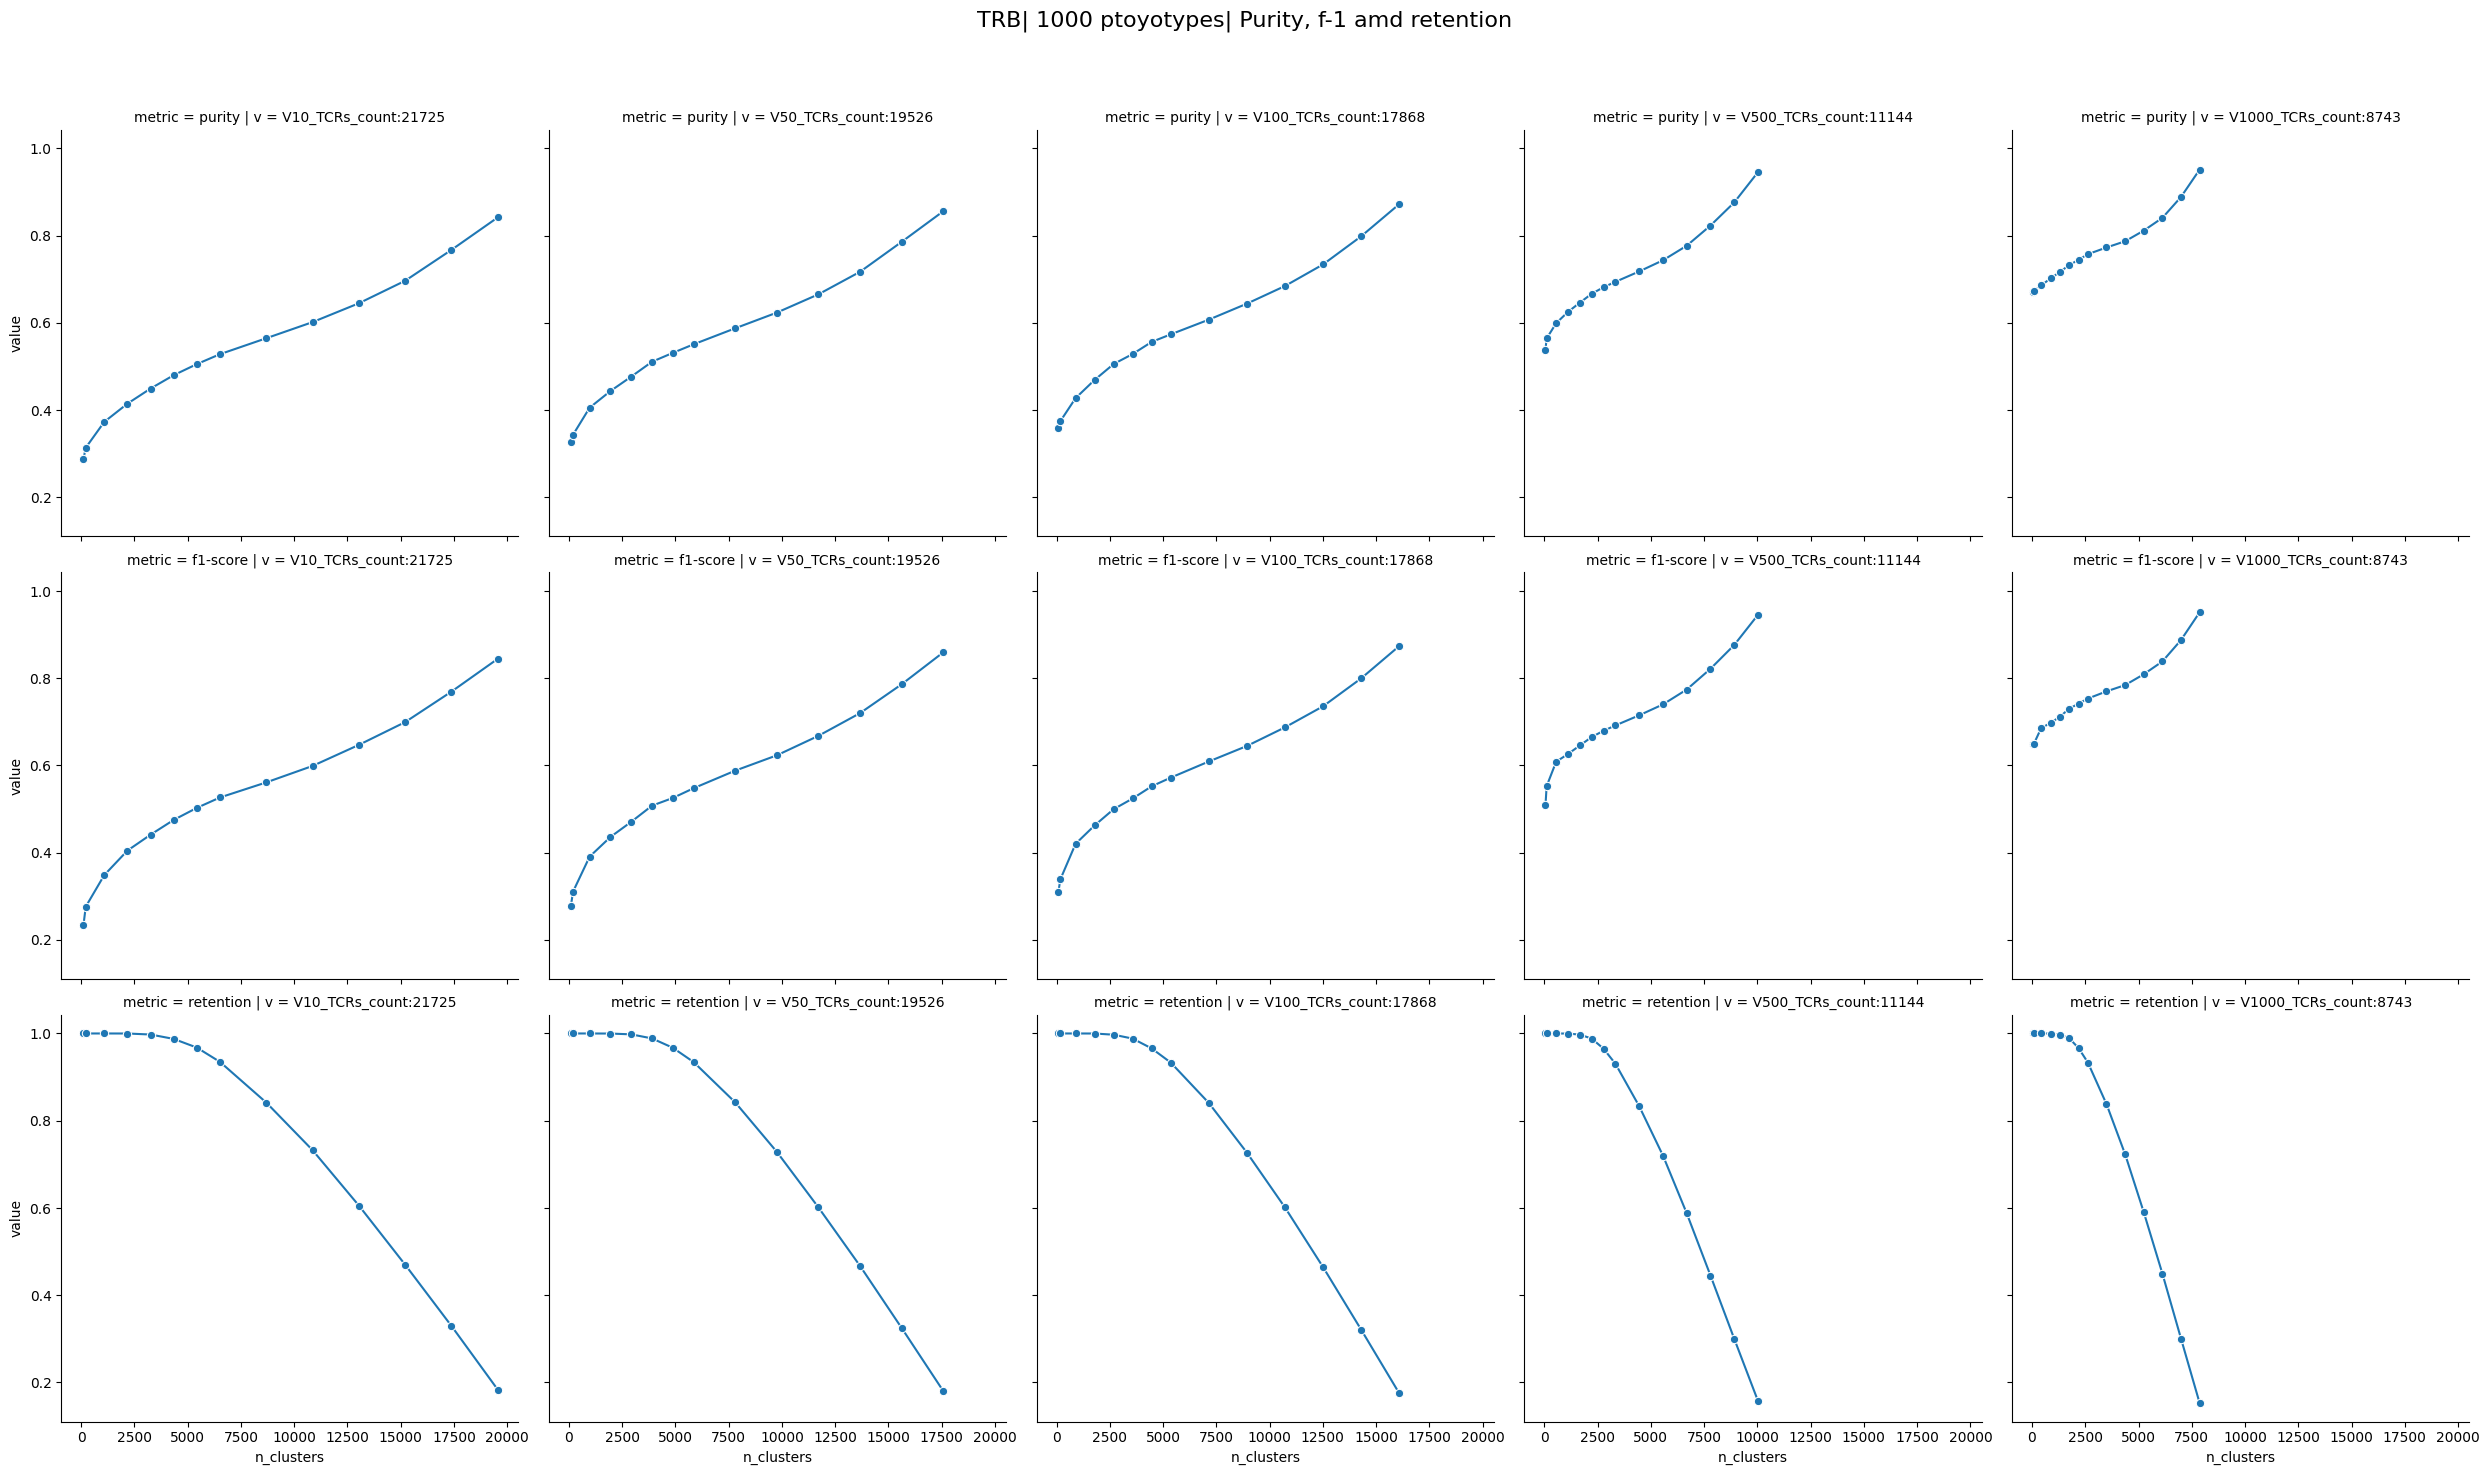

In [22]:
metrics_df = pd.DataFrame(metrics_tcremb[method][n_prototypes][chain]).T
t = metrics_df[['purity','f1-score','retention','n_clusters','v']].melt(id_vars=['n_clusters','v'],var_name='metric')
g = sns.relplot(data = t, x = 'n_clusters', y = 'value', hue='v', row='metric',kind="line",marker='o')
g.fig.suptitle(f'{chain}| {n_prototypes} ptoyotypes| Purity, f-1 amd retention', fontsize=16)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig(f"figures/tcremb_compare_{n_prototypes}_{method}_{chain}.png")

In [23]:
n_prototypes = 5000
metrics_tcremb[method][n_prototypes]={}

In [ ]:


chain = 'TRA'
metrics_tcremb[method][n_prototypes][chain]={}
for i in samples_n:
    run_name = f'compare_V{i}_{n_prototypes}'
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
    tcremb.tcremb_clonotypes(chain)
    tcremb.tcremb_dists(chain)
    tcremb.tcremb_pca(chain)
    tcremb.tcremb_tsne(chain)
    
    data_len = len(tcremb.pca_clones[chain])
    
    range_n_clusters = [round(data_len*0.005),round(data_len*0.01), round(data_len*0.05) , round(data_len*0.1), round(data_len*0.15)                    
                        ,round(data_len*0.2), round(data_len*0.25), round(data_len*0.3)
                        , round(data_len*0.4), round(data_len*0.5), round(data_len*0.6), round(data_len*0.7), round(data_len*0.8), round(data_len*0.9)]
    
    for j in range_n_clusters:
        dbscan = TCRemb.TCRemb_clustering(method)
        model = KMeans(n_clusters=j)
        dbscan.clstr(chain,tcremb, label, model=model)
        t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}'] = metrics.get_clustermetrics(t, label)
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}']['n_clusters']=j
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}']['v']=f'V{i}_TCRs_count:{len(tcremb.pca_clones[chain])}'

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


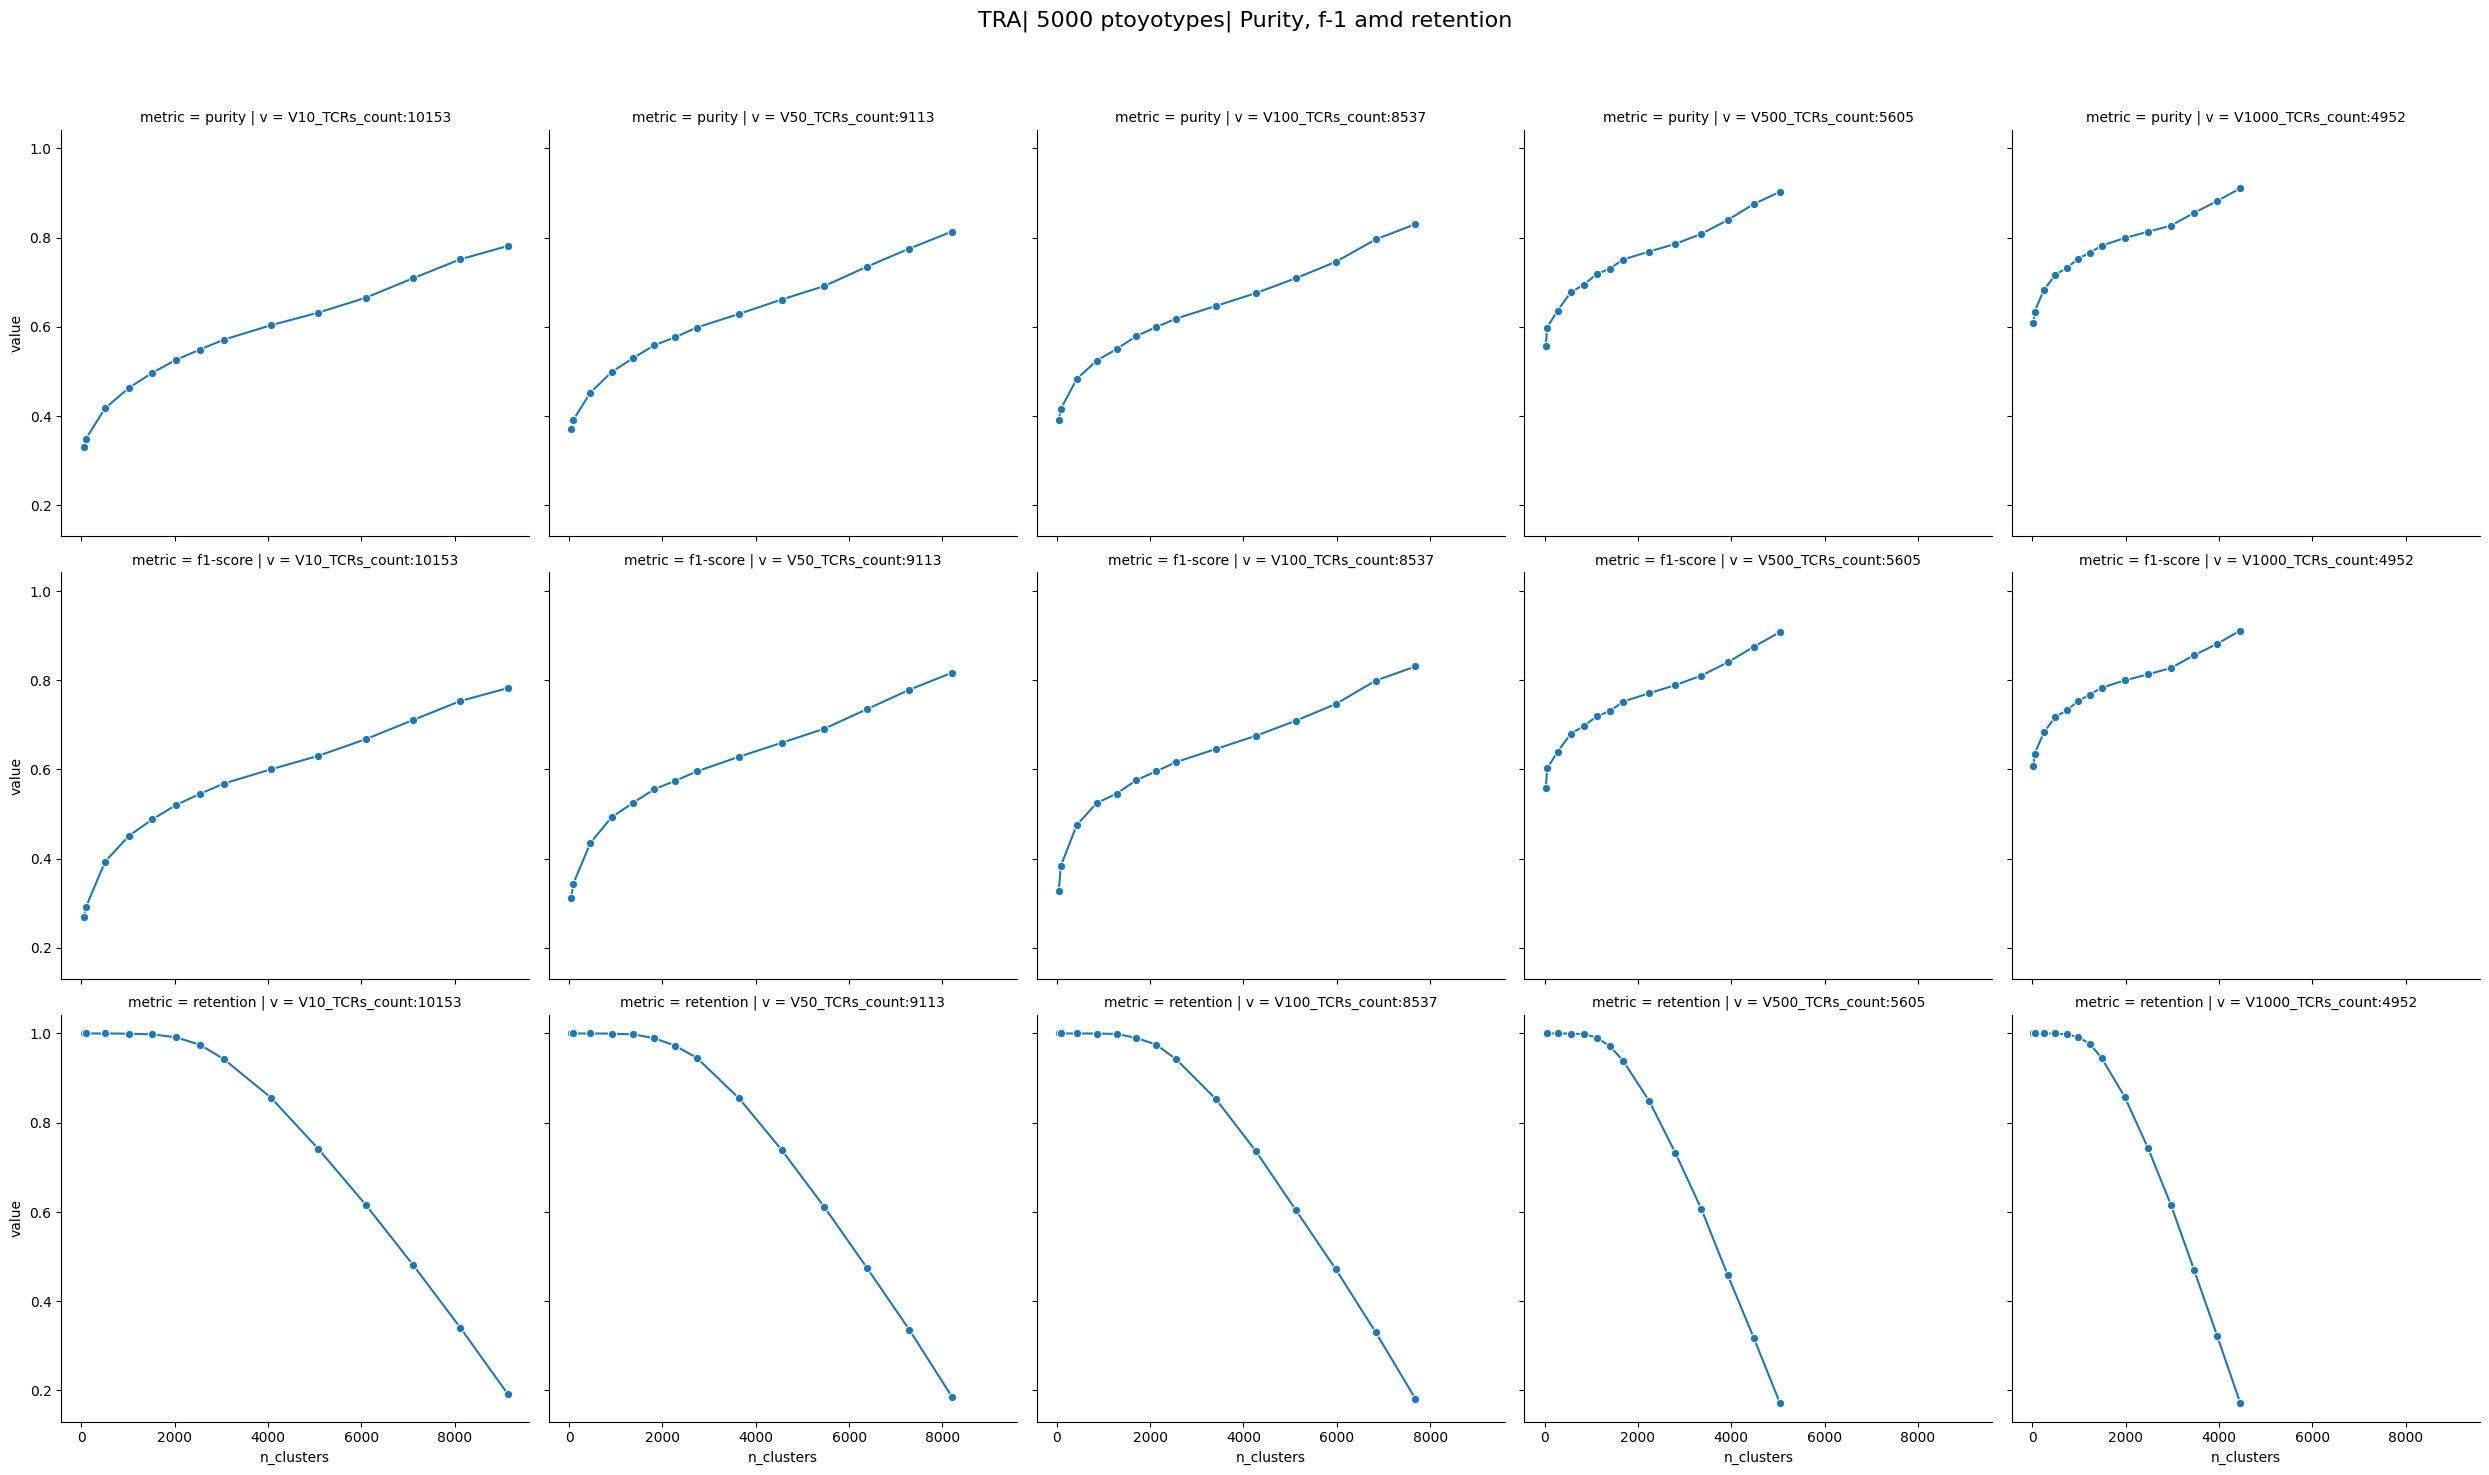

In [25]:
metrics_df = pd.DataFrame(metrics_tcremb[method][n_prototypes][chain]).T
t = metrics_df[['purity','f1-score','retention','n_clusters','v']].melt(id_vars=['n_clusters','v'],var_name='metric')
g = sns.relplot(data = t, x = 'n_clusters', y = 'value', hue='v', row='metric',kind="line",marker='o')
g.fig.suptitle(f'{chain}| {n_prototypes} ptoyotypes| Purity, f-1 amd retention', fontsize=16)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig(f"figures/tcremb_compare_{n_prototypes}_{method}_{chain}.png")

In [ ]:


chain = 'TRB'
metrics_tcremb[method][n_prototypes][chain]={}
for i in samples_n:
    run_name = f'compare_V{i}_{n_prototypes}'
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
    tcremb.tcremb_clonotypes(chain)
    tcremb.tcremb_dists(chain)
    tcremb.tcremb_pca(chain)
    tcremb.tcremb_tsne(chain)
    
    data_len = len(tcremb.pca_clones[chain])
    
    range_n_clusters = [round(data_len*0.005),round(data_len*0.01), round(data_len*0.05) , round(data_len*0.1), round(data_len*0.15)                    
                        ,round(data_len*0.2), round(data_len*0.25), round(data_len*0.3)
                        , round(data_len*0.4), round(data_len*0.5), round(data_len*0.6), round(data_len*0.7), round(data_len*0.8), round(data_len*0.9)]
    
    for j in range_n_clusters:
        dbscan = TCRemb.TCRemb_clustering(method)
        model = KMeans(n_clusters=j)
        dbscan.clstr(chain,tcremb, label, model=model)
        t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}'] = metrics.get_clustermetrics(t, label)
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}']['n_clusters']=j
        metrics_tcremb[method][n_prototypes][chain][f'{i}_{j}']['v']=f'V{i}_TCRs_count:{len(tcremb.pca_clones[chain])}'

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


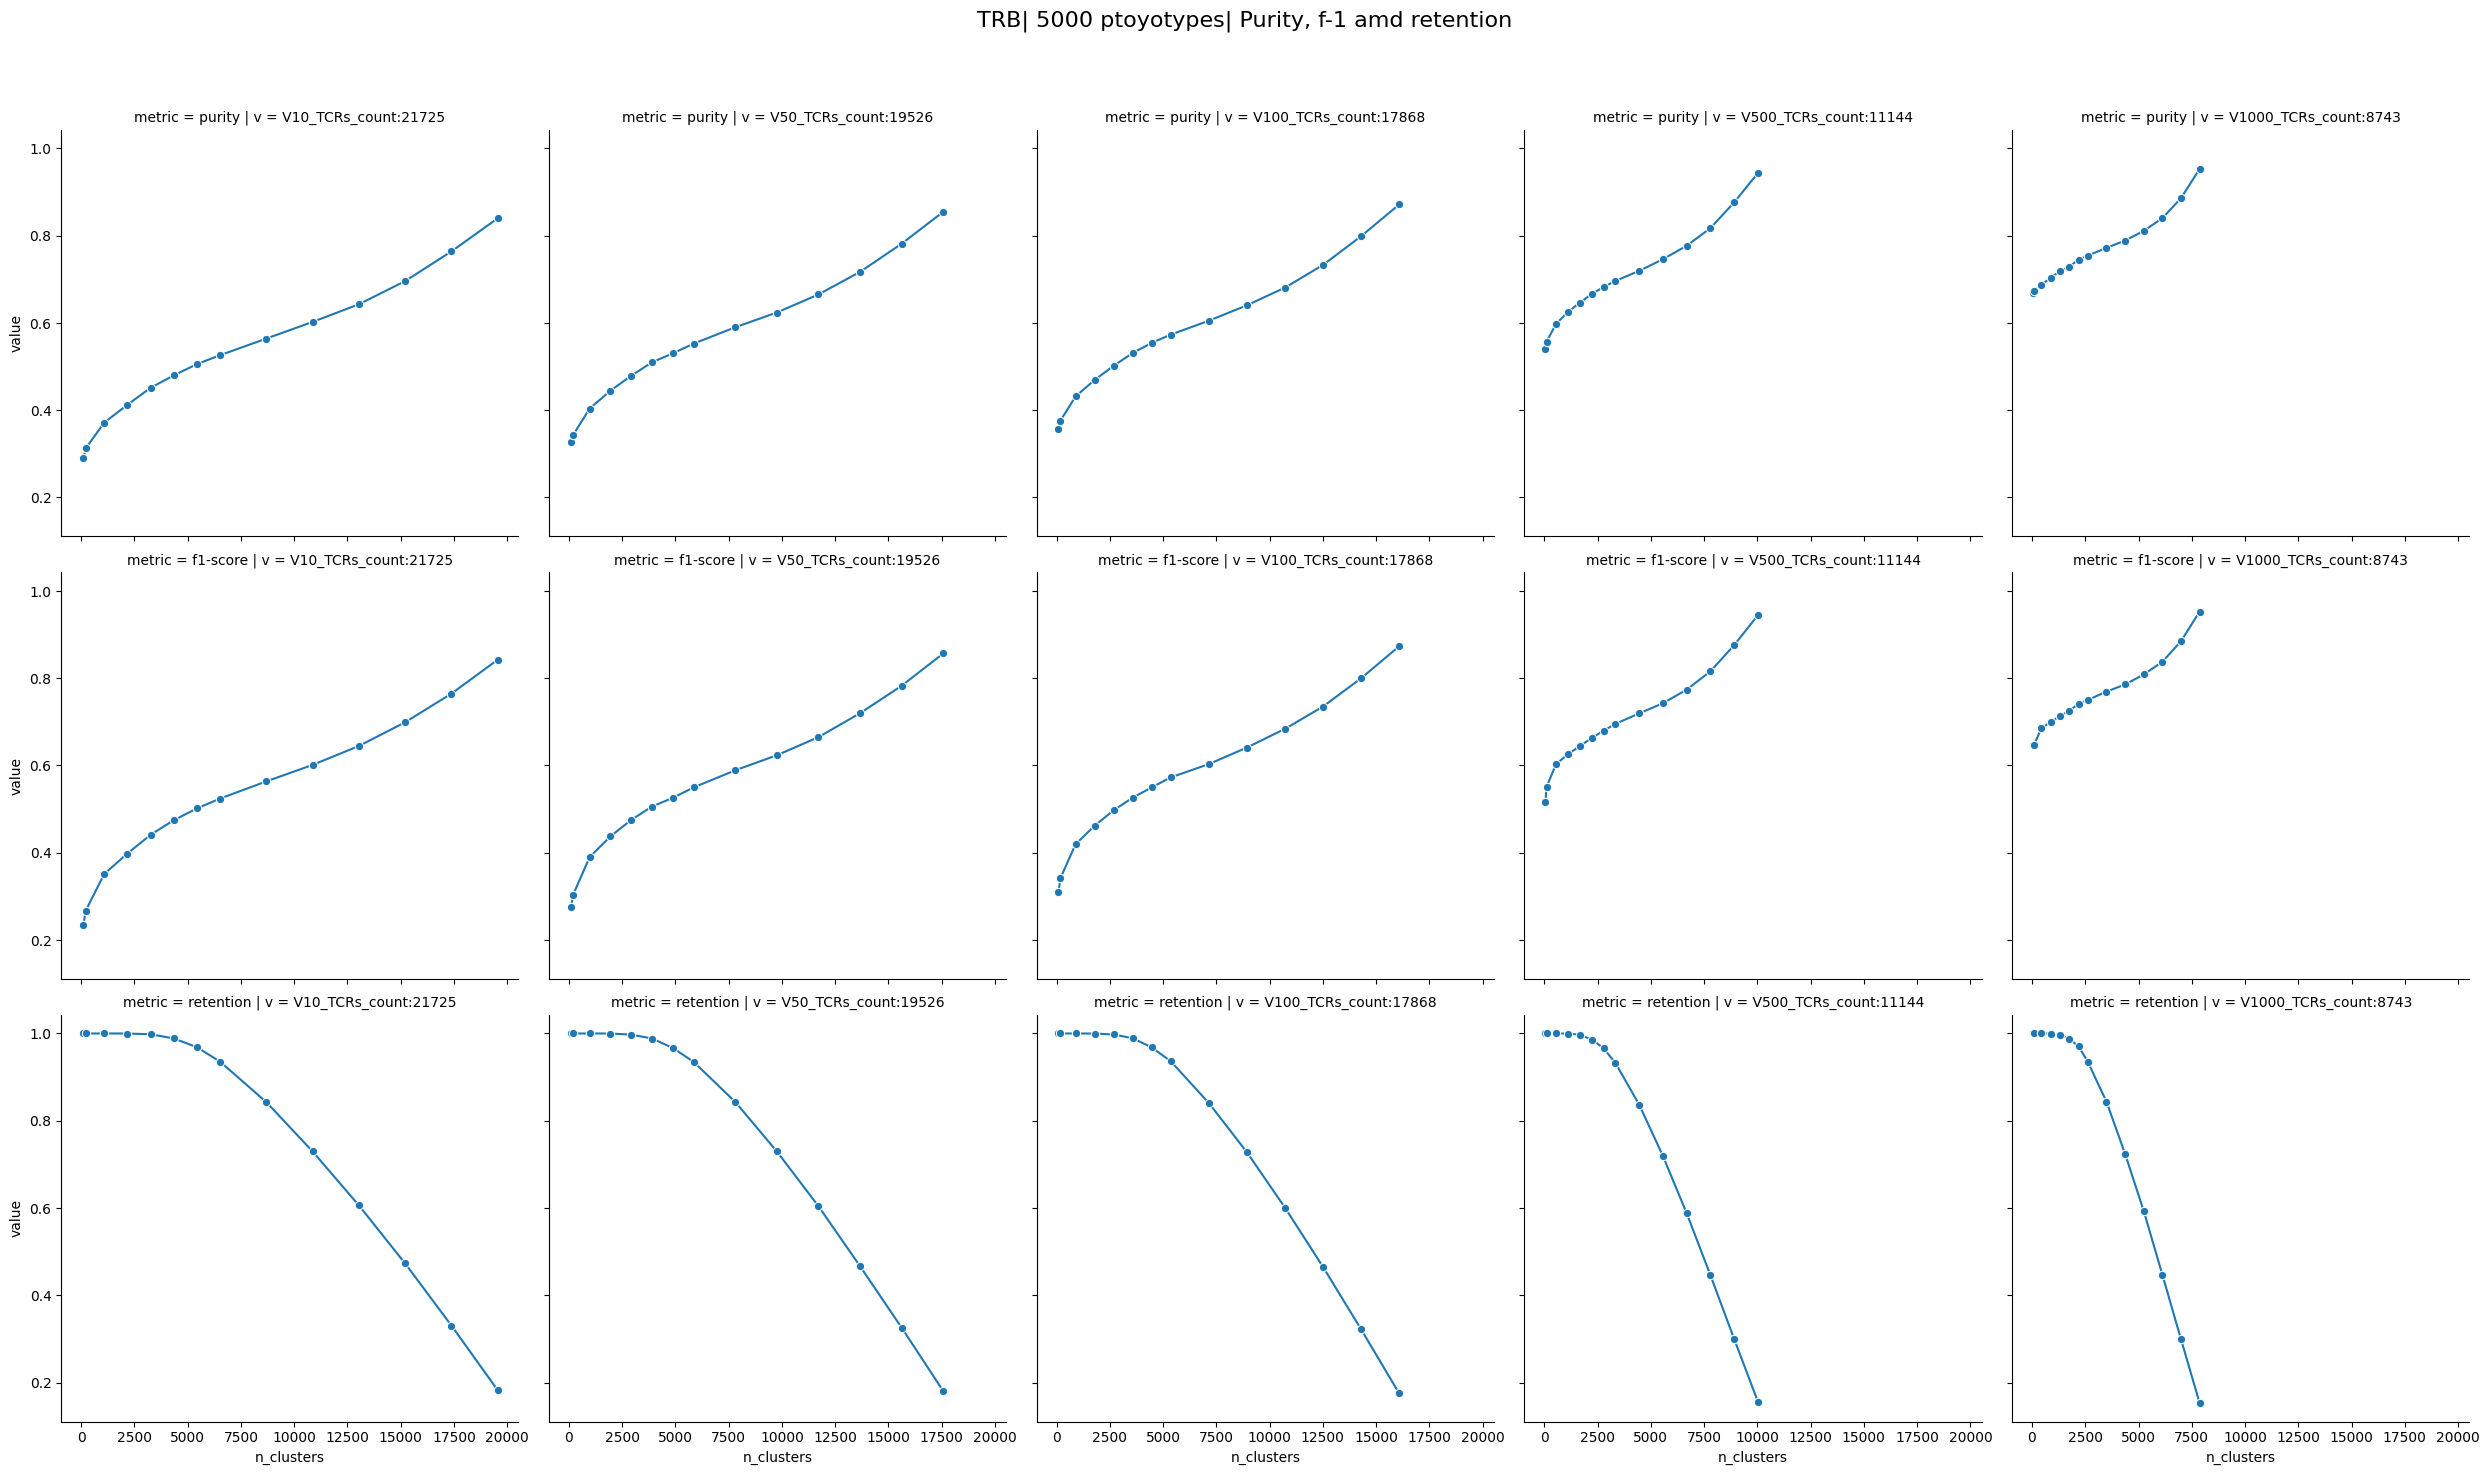

In [27]:
metrics_df = pd.DataFrame(metrics_tcremb[method][n_prototypes][chain]).T
t = metrics_df[['purity','f1-score','retention','n_clusters','v']].melt(id_vars=['n_clusters','v'],var_name='metric')
g = sns.relplot(data = t, x = 'n_clusters', y = 'value', hue='v', row='metric',kind="line",marker='o')
g.fig.suptitle(f'{chain}| {n_prototypes} ptoyotypes| Purity, f-1 amd retention', fontsize=16)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig(f"figures/tcremb_compare_{n_prototypes}_{method}_{chain}.png")

## compare prototypes

In [5]:
#prototypes_n = [3000]
prototypes_n = [100,150,300,500, 1000, 3000,5000]
samples_n = [10,50,100,500,1000]
#samples_n = [500,1000]

In [6]:
protos_metrics_tcremb = {}


In [7]:
method='dbscan'
protos_metrics_tcremb[method]={}

TCR-epitope paires count in V500 dataset: 5634
data/data_preped/VDJdb_data_TRA_V500.csv
{'TRA': 'data/data_preped/olga_humanTRA.txt', 'TRB': 'data/data_preped/olga_humanTRB.txt'}


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


purity:0.9154228855721394
TCR-epitope paires count in V1000 dataset: 4971
data/data_preped/VDJdb_data_TRA_V1000.csv
{'TRA': 'data/data_preped/olga_humanTRA.txt', 'TRB': 'data/data_preped/olga_humanTRB.txt'}


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


purity:0.9230769230769231


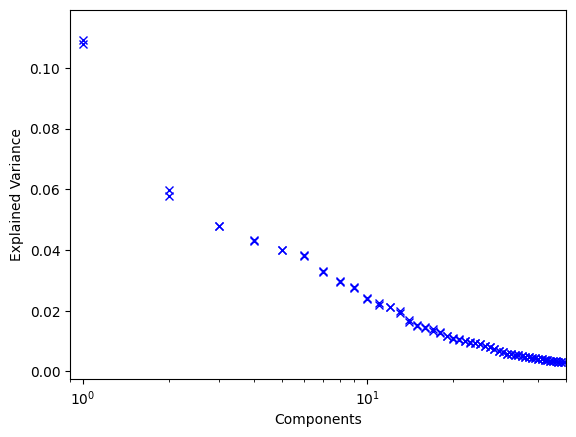

In [12]:


chain = 'TRA'
protos_metrics_tcremb[method][chain]={}
for i in samples_n:
    for j in prototypes_n:
        
        if j==3000:
            run_name = f'compare_V{i}'
        else:
            run_name = f'compare_V{i}_{j}'
        v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
        vdjdb_v = pd.read_csv(v_path,sep='\t')
        print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
        print(v_path)
    
        tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
        tcremb.tcremb_clonotypes(chain)
        tcremb.tcremb_dists(chain)
        tcremb.tcremb_pca(chain)
        tcremb.tcremb_tsne(chain)
    
        data_len = len(tcremb.pca_clones[chain])
    
        dbscan = TCRemb.TCRemb_clustering('dbscan')
        dbscan.clstr(chain,tcremb, label, model='dbscan')
        t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
        protos_metrics_tcremb[method][chain][f'V{i}_P{j}'] = metrics.get_clustermetrics(t, label)
        protos_metrics_tcremb[method][chain][f'V{i}_P{j}']['v']=f'V{i} dataset size:{len(tcremb.pca_clones[chain])}'
        protos_metrics_tcremb[method][chain][f'V{i}_P{j}']['n_prototypes']=j
    


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


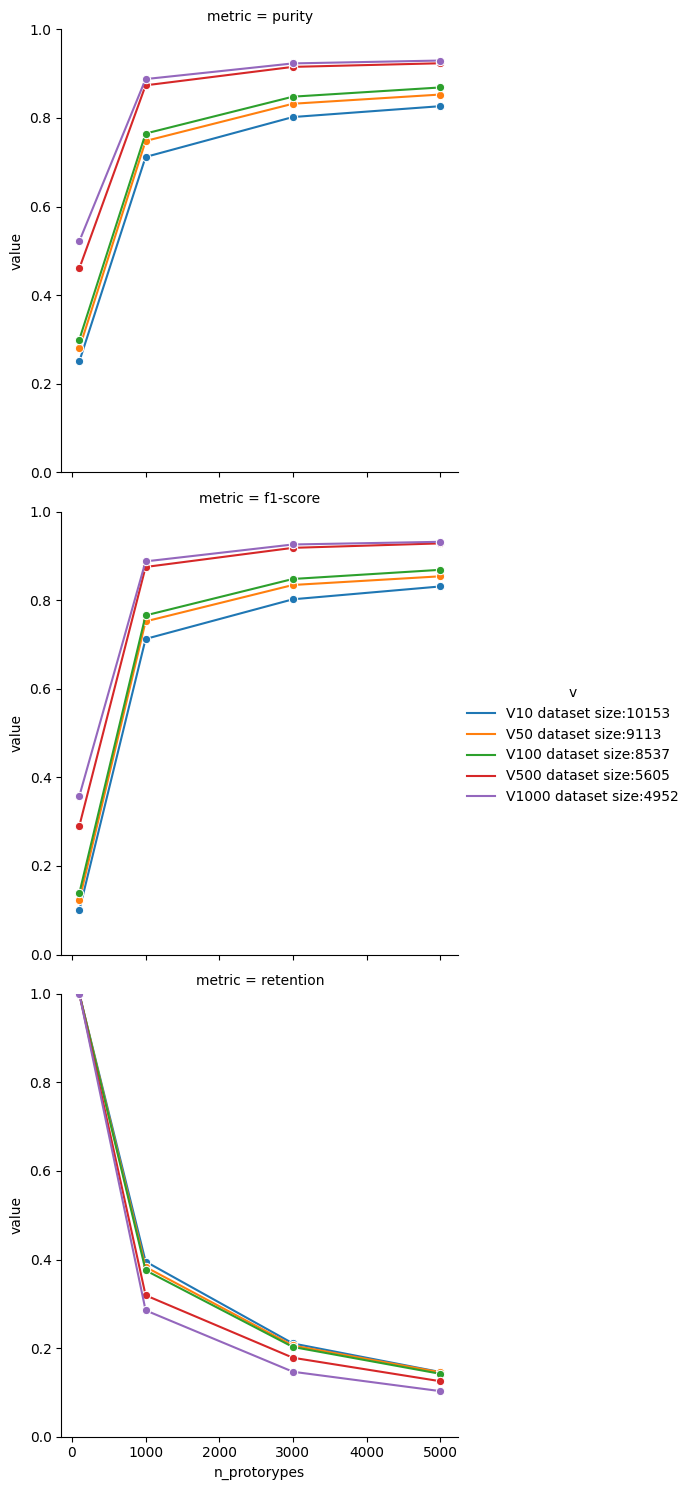

In [44]:
metrics_df = pd.DataFrame(protos_metrics_tcremb[method][chain]).T
t = metrics_df[['purity','f1-score','retention','n_prototypes','v']].melt(id_vars=['n_prototypes','v'],var_name='metric')
g = sns.relplot(data = t, x = 'n_prototypes', y = 'value', hue='v', row='metric',kind="line",marker='o')
g.set(ylim=(0, 1))
g.set(ylim=(0, 1))

In [11]:

metrics_tcremb={}
samples_n = [10,50,100,500,1000]
#samples_n = [10,1000]
prototypes_n = [100,150,300,500, 1000,2000, 3000,5000]
#prototypes_n = [100,3000]

In [12]:
method = 'dbscan'
params=[3, 10,25, 50,75, 100,150,200,250,300,350,400,450, 500,550, 600,650, 700,750, 800,850, 900,950, 1000, 1050,1100,1150, 1200,1250, 1300,1350, 1400,1450, 1500]
metrics_tcremb[method]={}

In [ ]:
chain = 'TRA'
metrics_tcremb[method][chain]={}
for n_prototypes in prototypes_n:
    for i in samples_n:
        #if n_prototypes==3000:
        #    run_name = f'compare_V{i}'
        #else:
        #    run_name = f'compare_V{i}_{n_prototypes}'
        run_name = f'compare_V{i}_{n_prototypes}'
        v_path = f'data/data_preped/VDJdb_data_V{i}.csv'
        vdjdb_v = pd.read_csv(v_path,sep='\t')
        print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
        print(v_path)
    
        tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
        tcremb.tcremb_clonotypes(chain)
        tcremb.tcremb_dists(chain)
        tcremb.tcremb_pca(chain)
        tcremb.tcremb_tsne(chain)
        
        data_len = len(tcremb.pca_clones[chain])
        
        for j in params:
            dbscan = TCRemb.TCRemb_clustering(method)
            model = DBSCAN(eps=j, min_samples=2)
            dbscan.clstr(chain,tcremb, label, model=model)
            t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}'] = metrics.get_clustermetrics(t, label)
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}']['n_prototypes']=n_prototypes
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}']['eps']=j
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}']['v']=f'V{i}_TCRs_count:{len(tcremb.pca_clones[chain])}'

In [ ]:
chain = 'TRB'
metrics_tcremb[method][chain]={}
for n_prototypes in prototypes_n:
    for i in samples_n:
        #if n_prototypes==3000:
        #    run_name = f'compare_V{i}'
        #else:
        #    run_name = f'compare_V{i}_{n_prototypes}'
        run_name = f'compare_V{i}_{n_prototypes}'
        v_path = f'data/data_preped/VDJdb_data_V{i}.csv'
        vdjdb_v = pd.read_csv(v_path,sep='\t')
        print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
        print(v_path)
    
        tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
        tcremb.tcremb_clonotypes(chain)
        tcremb.tcremb_dists(chain)
        tcremb.tcremb_pca(chain)
        tcremb.tcremb_tsne(chain)
        
        data_len = len(tcremb.pca_clones[chain])
        
        for j in params:
            dbscan = TCRemb.TCRemb_clustering(method)
            model = DBSCAN(eps=j, min_samples=2)
            dbscan.clstr(chain,tcremb, label, model=model)
            t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}'] = metrics.get_clustermetrics(t, label)
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}']['n_prototypes']=n_prototypes
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}']['eps']=j
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}']['v']=f'V{i}_TCRs_count:{len(tcremb.pca_clones[chain])}'

In [ ]:
chain = 'TRA_TRB'
metrics_tcremb[method][chain]={}
for n_prototypes in prototypes_n:
    for i in samples_n:
        #if n_prototypes==3000:
        #    run_name = f'compare_V{i}'
        #else:
        #    run_name = f'compare_V{i}_{n_prototypes}'
        run_name = f'compare_V{i}_{n_prototypes}'
        v_path = f'data/data_preped/VDJdb_data_V{i}.csv'
        vdjdb_v = pd.read_csv(v_path,sep='\t')
        print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
        print(v_path)
    
        tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
        tcremb.tcremb_clonotypes(chain)
        tcremb.tcremb_dists(chain)
        tcremb.tcremb_pca(chain)
        tcremb.tcremb_tsne(chain)
        
        data_len = len(tcremb.pca_clones[chain])
        
        for j in params:
            dbscan = TCRemb.TCRemb_clustering(method)
            model = DBSCAN(eps=j, min_samples=2)
            dbscan.clstr(chain,tcremb, label, model=model)
            t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}'] = metrics.get_clustermetrics(t, label)
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}']['n_prototypes']=n_prototypes
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}']['eps']=j
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}']['v']=f'V{i}_TCRs_count:{len(tcremb.pca_clones[chain])}'

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


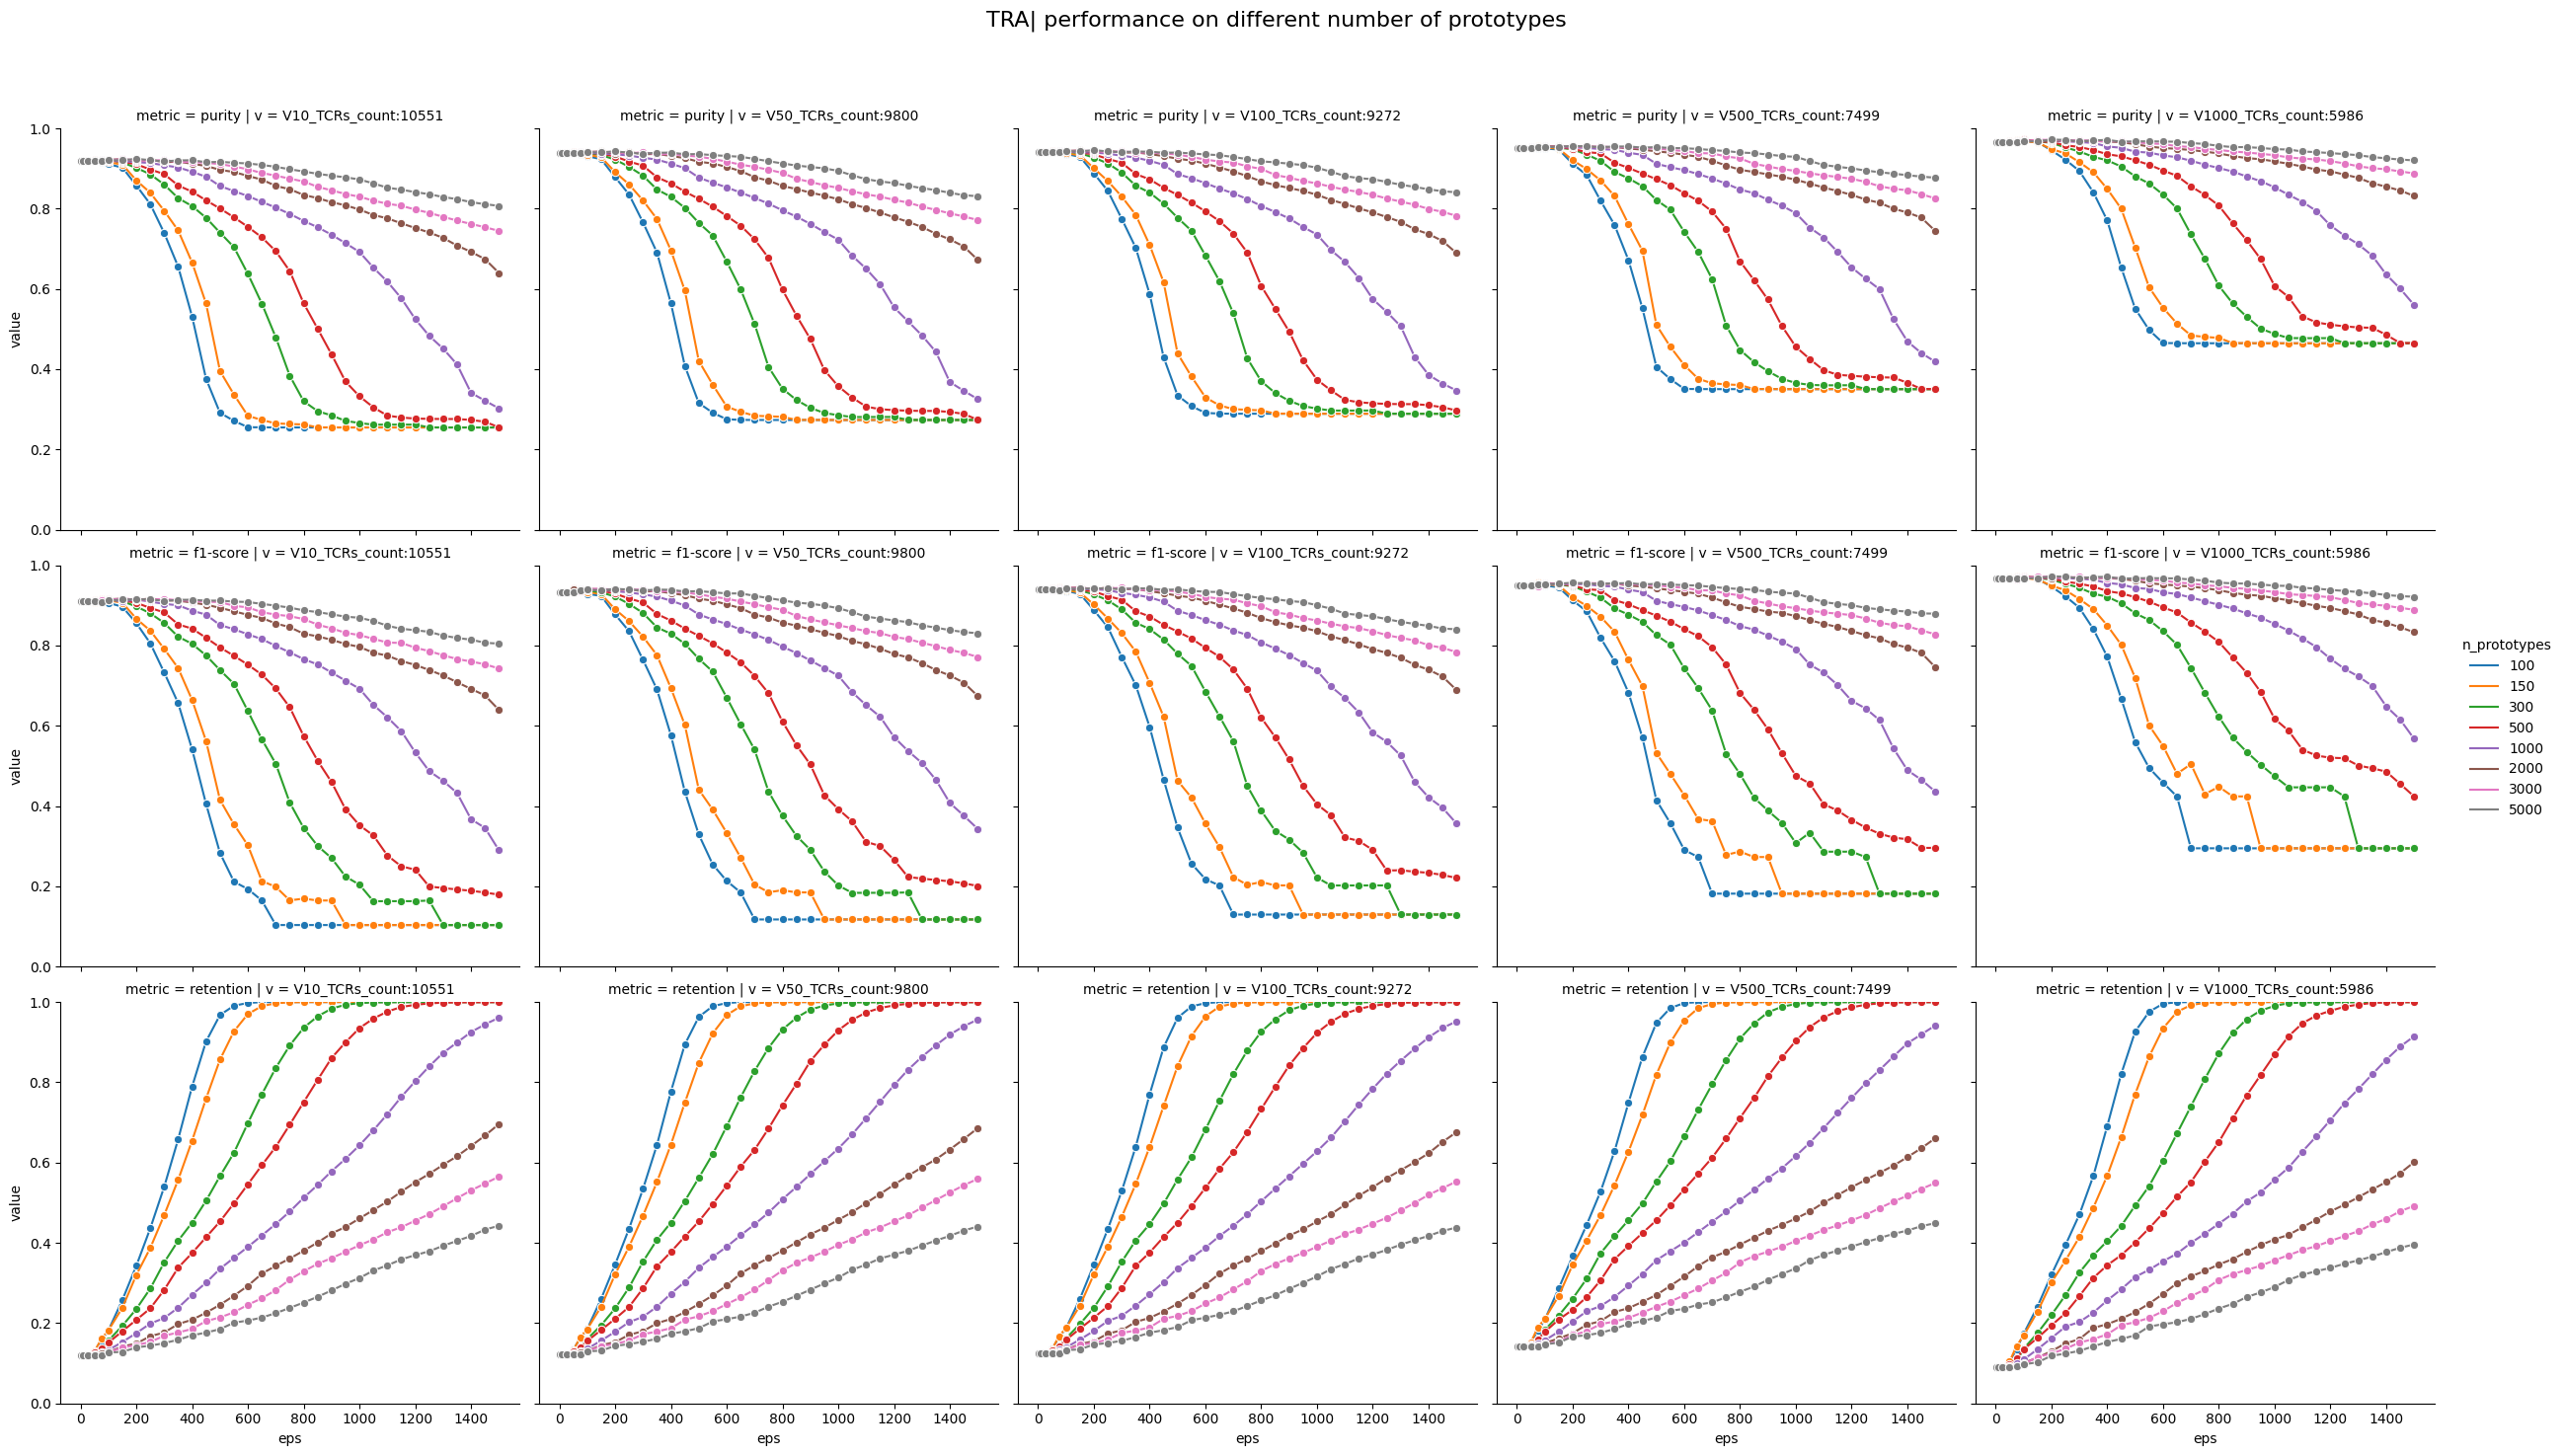

In [16]:
chain='TRA'
metrics_df = pd.DataFrame(metrics_tcremb[method][chain]).T
metrics_df['n_prototypes']=metrics_df['n_prototypes'].astype(str)
t = metrics_df[['purity','f1-score','retention','n_prototypes','v','eps']].melt(id_vars=['n_prototypes','v','eps'],var_name='metric')
g = sns.relplot(data = t, x = 'eps', y = 'value', hue='n_prototypes', row='metric',col='v',kind="line",marker='o')
g.set(ylim=(0, 1))
g.fig.suptitle(f'{chain}| performance on different number of prototypes', fontsize=16)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig(f"figures/tcremb_compare_prototypes_{method}_{chain}.png")

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


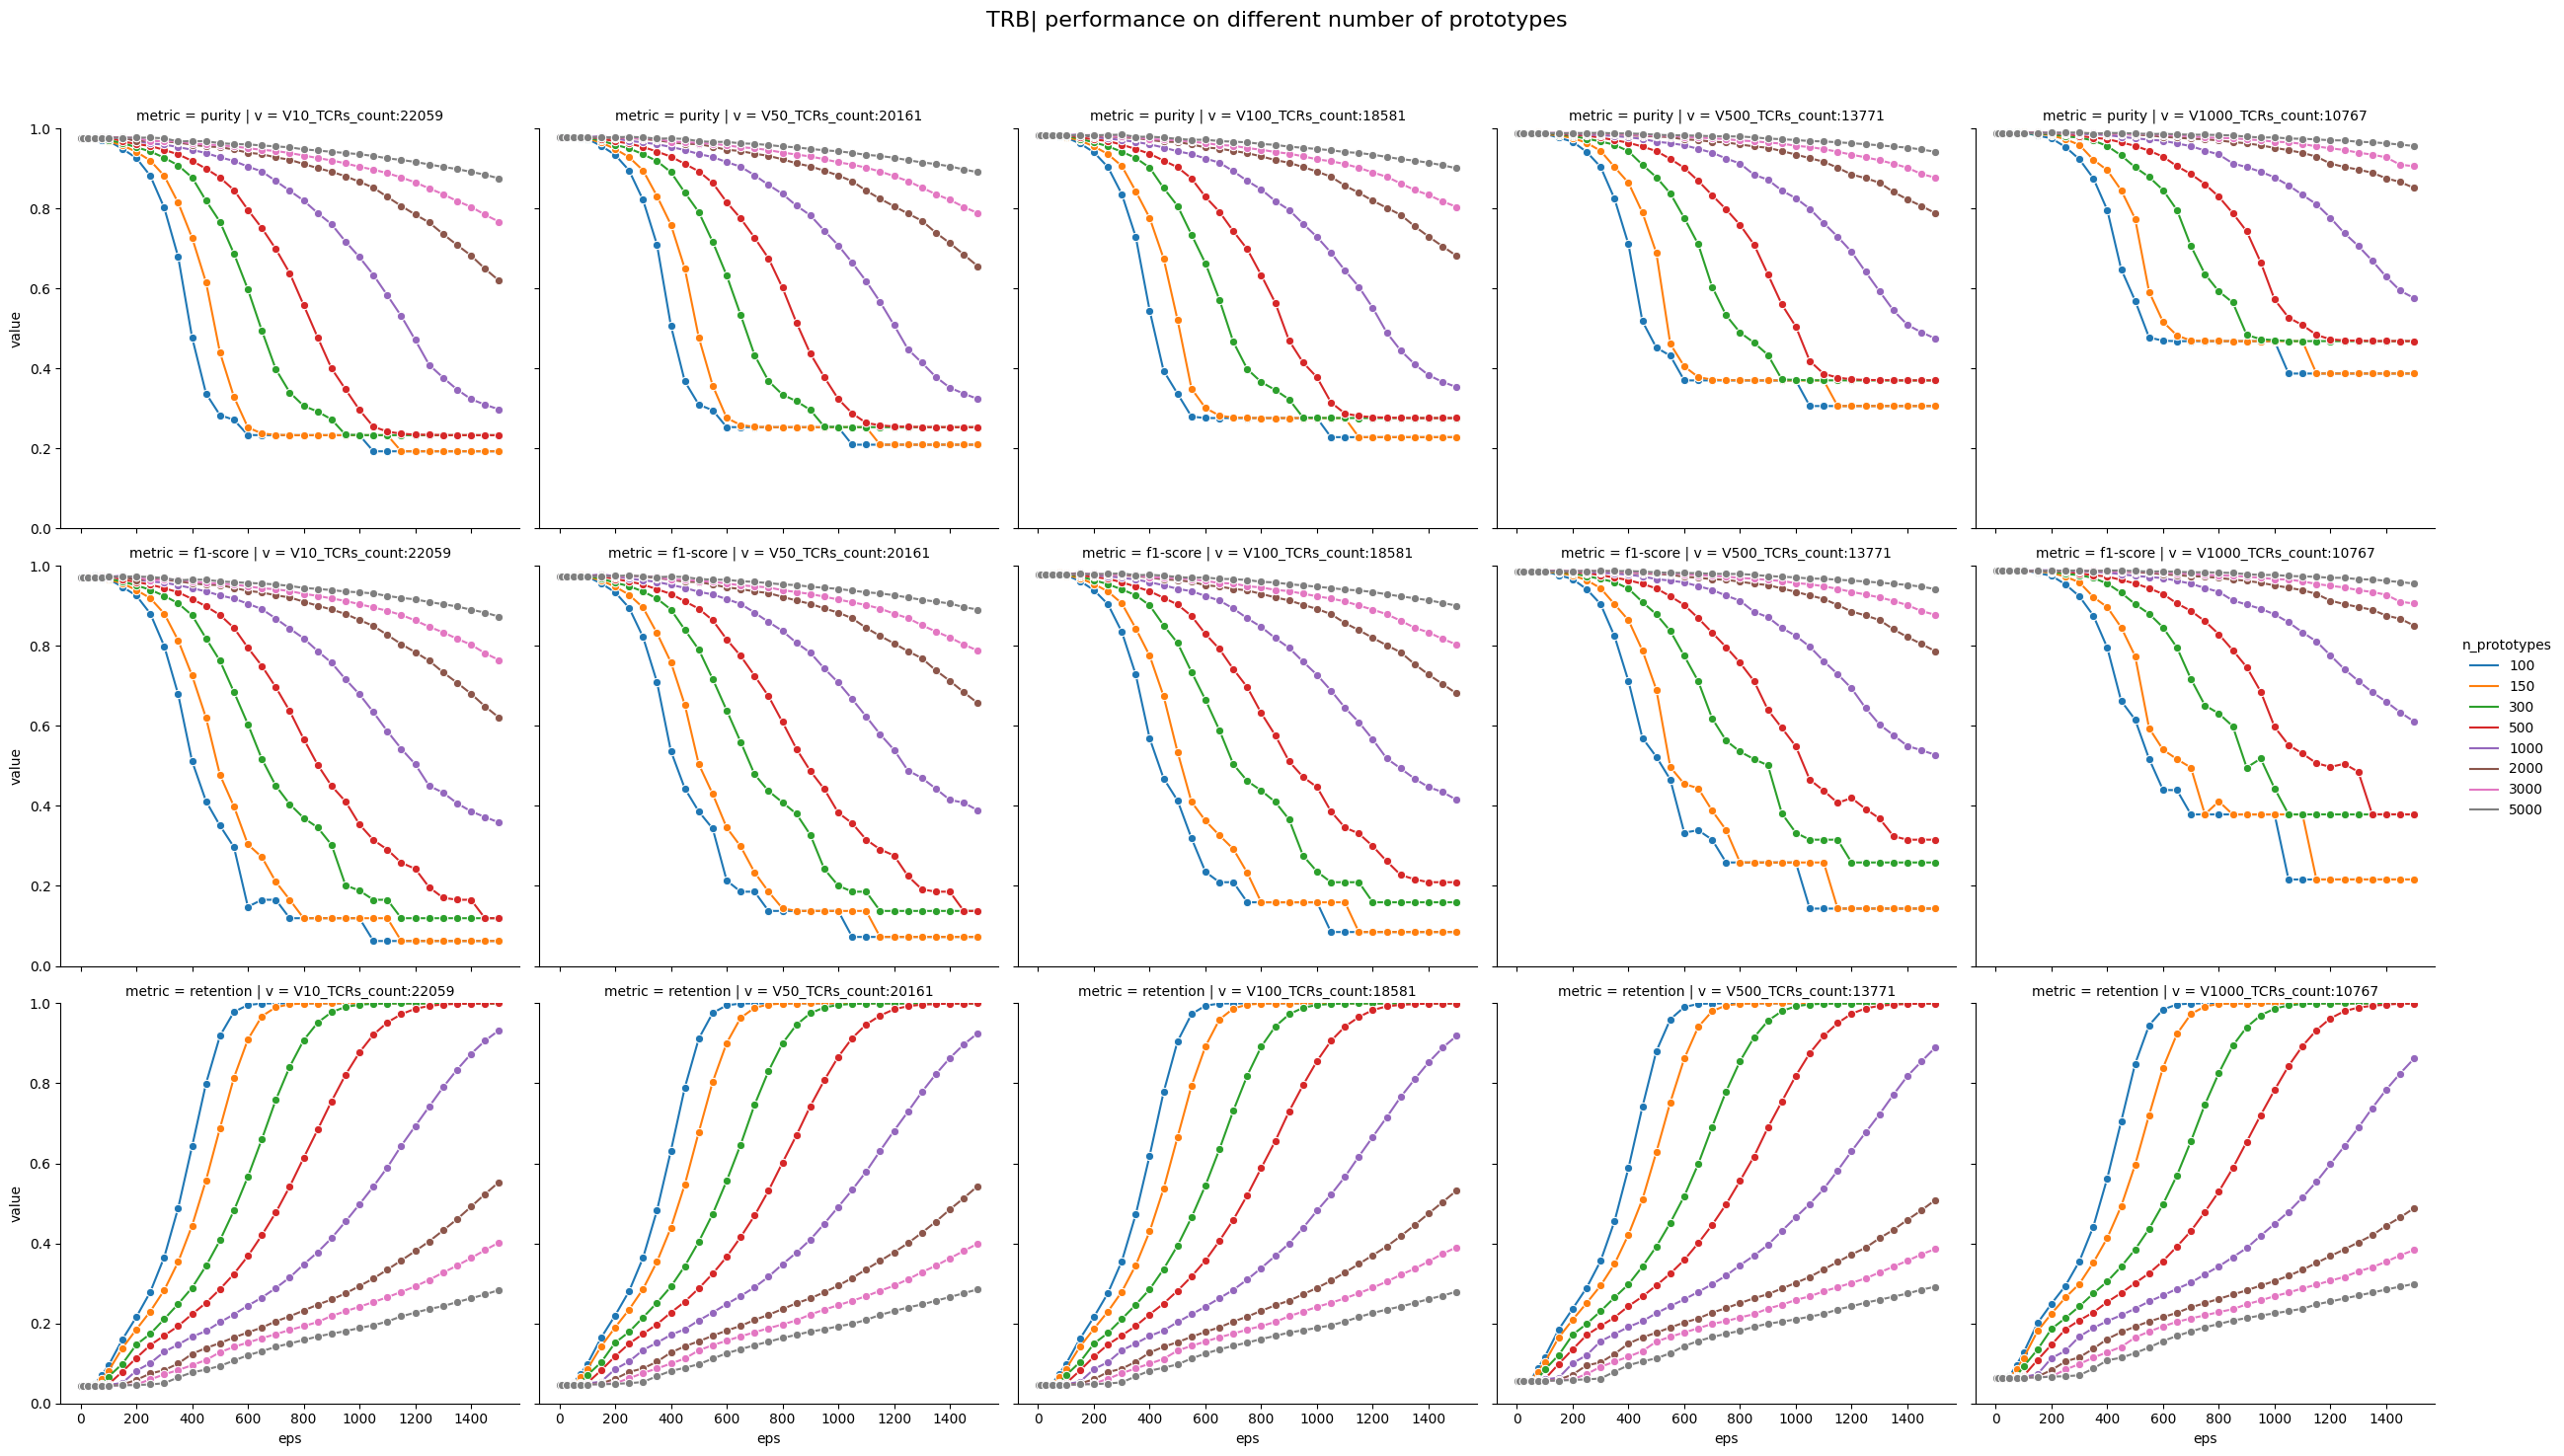

In [17]:
chain='TRB'
metrics_df = pd.DataFrame(metrics_tcremb[method][chain]).T
metrics_df['n_prototypes']=metrics_df['n_prototypes'].astype(str)
t = metrics_df[['purity','f1-score','retention','n_prototypes','v','eps']].melt(id_vars=['n_prototypes','v','eps'],var_name='metric')
g = sns.relplot(data = t, x = 'eps', y = 'value', hue='n_prototypes', row='metric',col='v',kind="line",marker='o')
g.set(ylim=(0, 1))
g.fig.suptitle(f'{chain}| performance on different number of prototypes', fontsize=16)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig(f"figures/tcremb_compare_prototypes_{method}_{chain}.png")

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


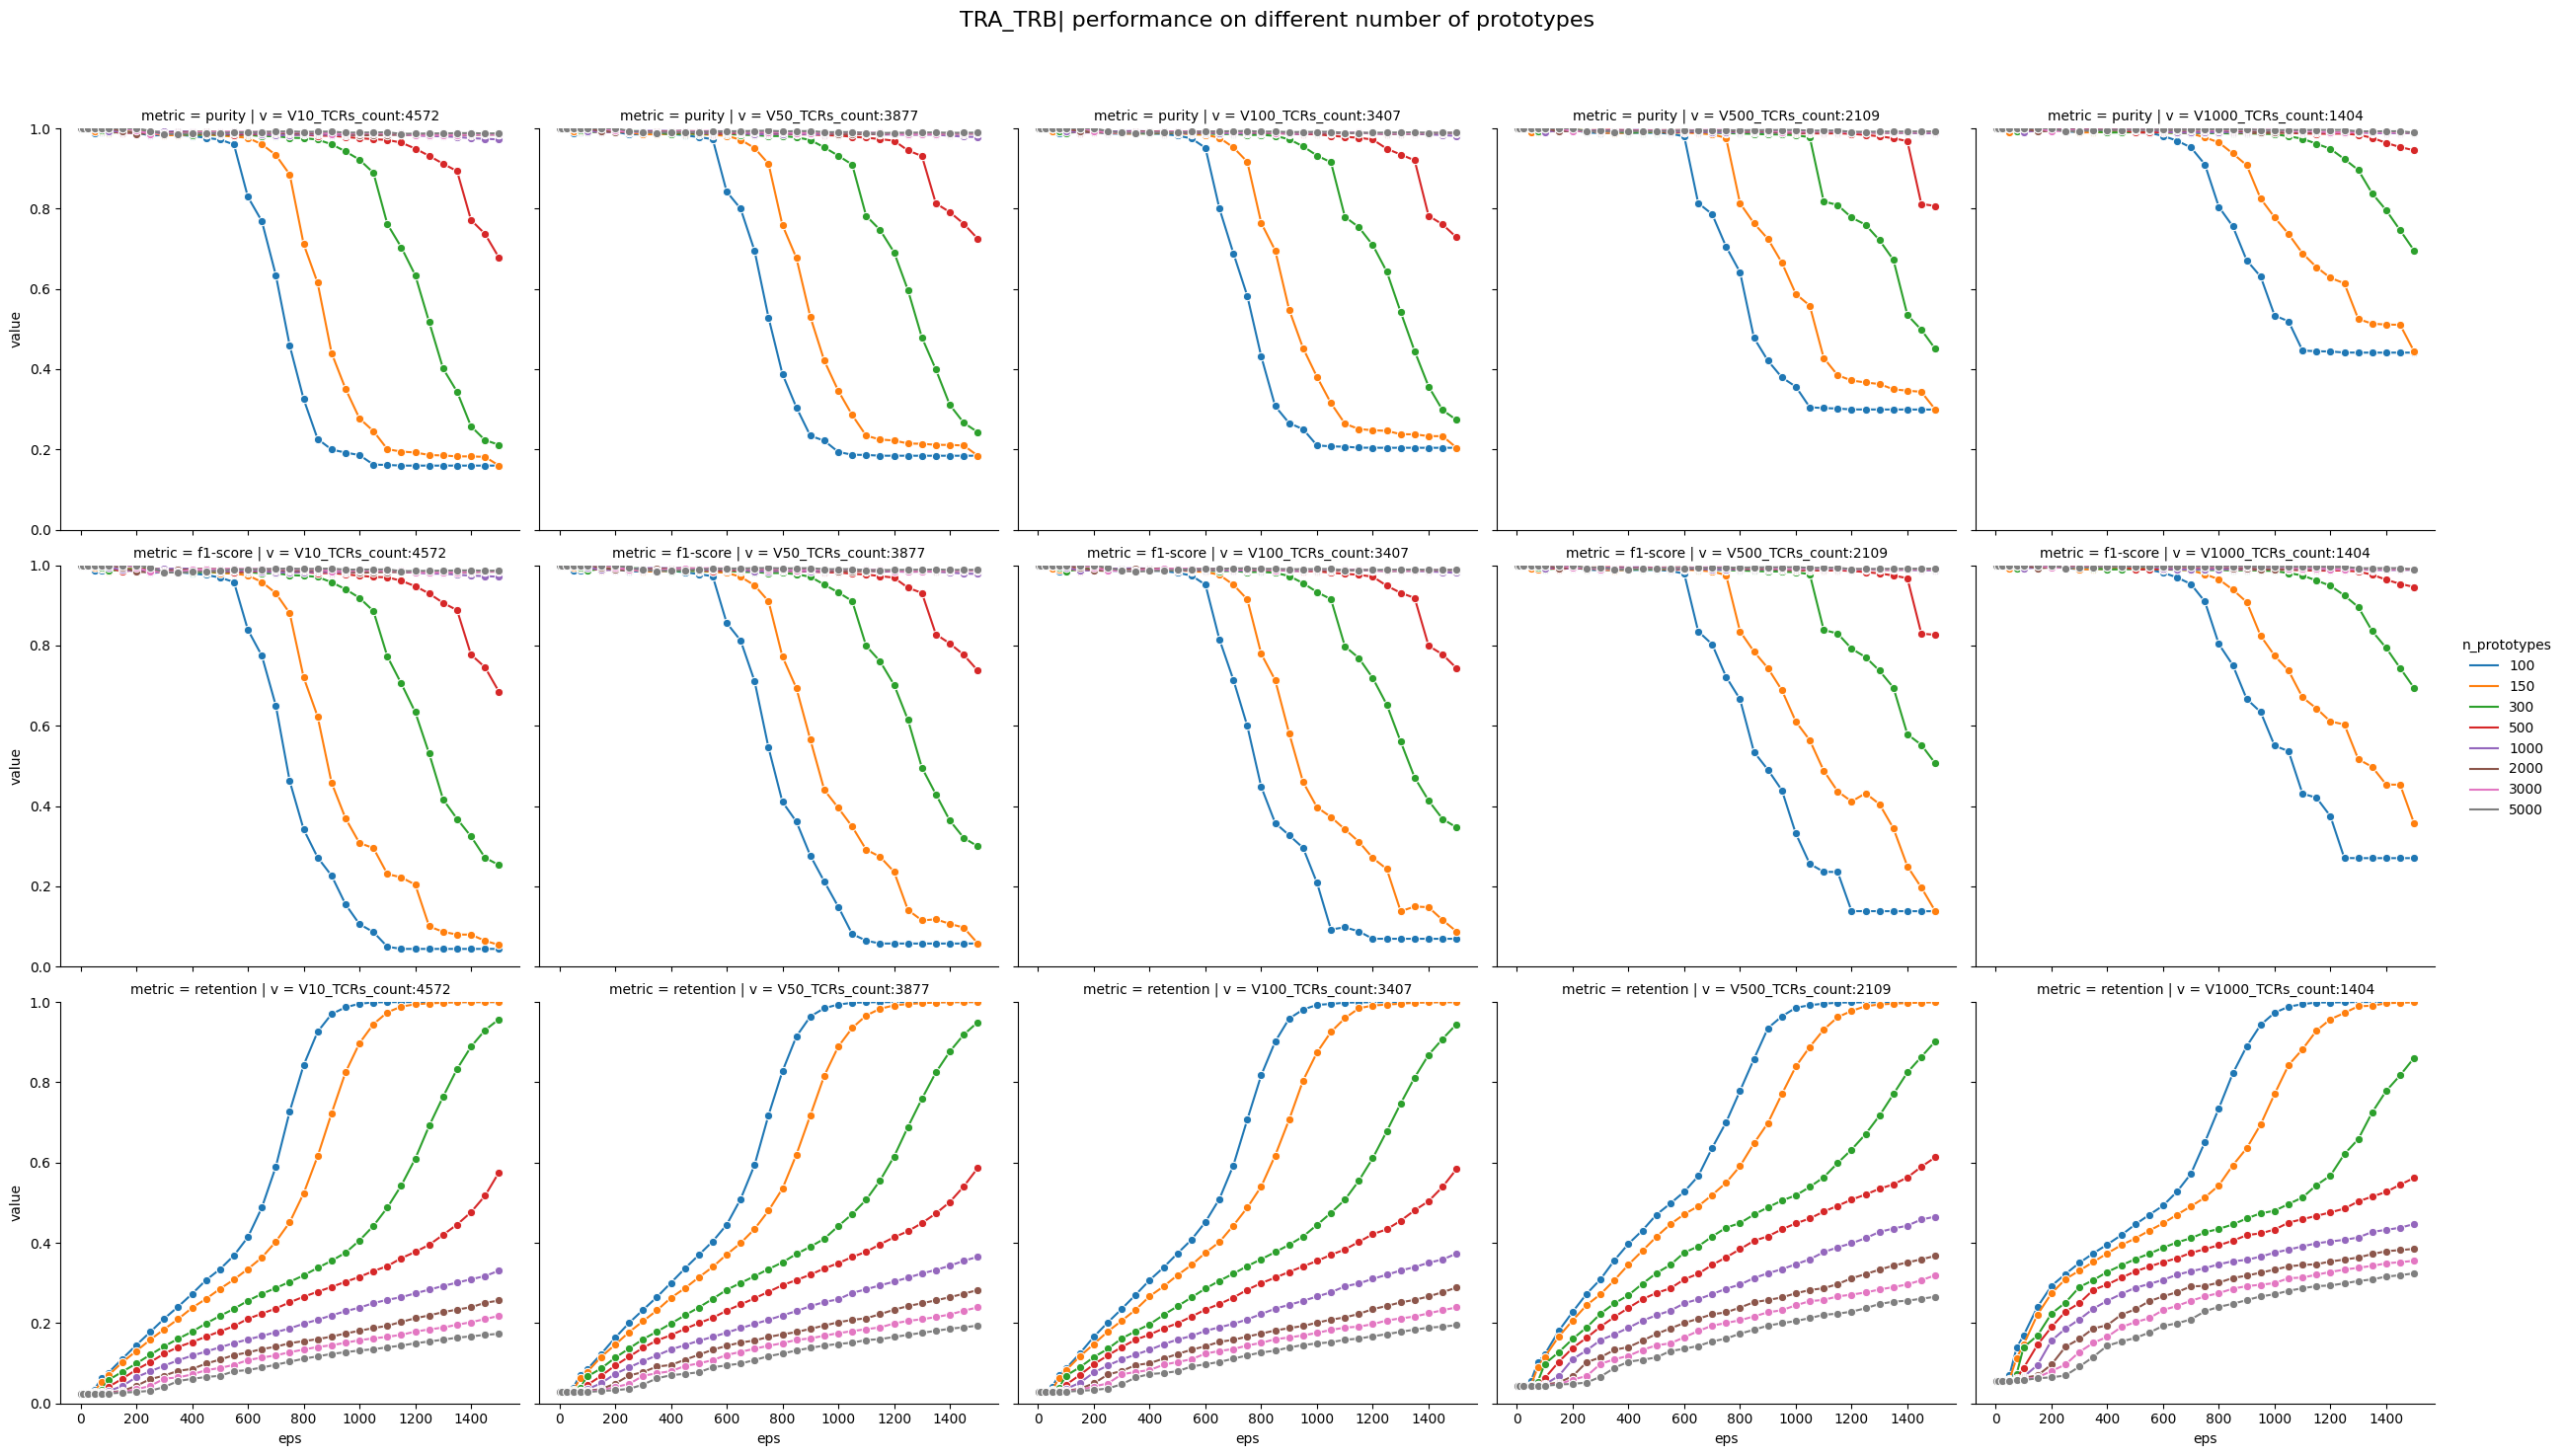

In [18]:
chain='TRA_TRB'
metrics_df = pd.DataFrame(metrics_tcremb[method][chain]).T
metrics_df['n_prototypes']=metrics_df['n_prototypes'].astype(str)
t = metrics_df[['purity','f1-score','retention','n_prototypes','v','eps']].melt(id_vars=['n_prototypes','v','eps'],var_name='metric')
g = sns.relplot(data = t, x = 'eps', y = 'value', hue='n_prototypes', row='metric',col='v',kind="line",marker='o')
g.set(ylim=(0, 1))
g.fig.suptitle(f'{chain}| performance on different number of prototypes', fontsize=16)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig(f"figures/tcremb_compare_prototypes_{method}_{chain}.png")

In [26]:
metrics_df = pd.DataFrame(metrics_tcremb[method][chain]).T

In [29]:
metrics_df[(metrics_df['n_prototypes']==100)&(metrics_df['eps']==750)]

purity retention consistency       ami  accuracy precision  \
V10_P100_e750    0.231076  0.999909    0.003147  0.031215  0.004562   0.08045   
V50_P100_e750    0.257536  0.999899    0.008225  0.033099  0.005082  0.099912   
V100_P100_e750   0.282043  0.999889    0.013549  0.035477  0.005563  0.119725   
V500_P100_e750   0.455946  0.999821    0.082736  0.048124  0.074318  0.311905   
V1000_P100_e750  0.582095  0.999657    0.166362  0.053519  0.333108  0.511424   

                   recall  f1-score support mean_clustsize n_prototypes  eps  \
V10_P100_e750    0.231076  0.119349   22036         4407.2          100  750   
V50_P100_e750    0.257536  0.143971   19772         3954.4          100  750   
V100_P100_e750   0.282043  0.168095   18054         3610.8          100  750   
V500_P100_e750   0.455946  0.370415   11168         2233.6          100  750   
V1000_P100_e750  0.582095  0.544475    8746         1749.2          100  750   

                                     v  
V10_P100_e750     V10_TCRs_count:21725  
V50_P100_e750     V50_TCRs_count:19526  
V100_P100_e750   V100_TCRs_count:17868  
V500_P100_e750   V500_TCRs_count:11144  
V1000_P100_e750  V1000_TCRs_count:8743

In [28]:
metrics_df[(metrics_df['n_prototypes']==3000)&(metrics_df['eps']==750)]

purity retention consistency       ami  accuracy  \
V10_P3000_e750    0.899023  0.125374    0.001283  0.850472  0.003967   
V50_P3000_e750    0.913341  0.125468    0.001911  0.855586  0.004418   
V100_P3000_e750   0.921006  0.125498    0.002659  0.854885  0.004835   
V500_P3000_e750   0.960133  0.134736    0.012846  0.856825  0.180793   
V1000_P3000_e750  0.968481  0.119671    0.028335  0.787893  0.250983   

                 precision    recall  f1-score support mean_clustsize  \
V10_P3000_e750    0.893651  0.899023  0.896329    2763       3.216531   
V50_P3000_e750    0.909437  0.913341  0.911385    2481       3.273087   
V100_P3000_e750    0.92123  0.921006  0.921118    2266        3.34712   
V500_P3000_e750   0.960617  0.960133  0.960375    1505       3.753117   
V1000_P3000_e750  0.967991  0.968481  0.968236    1047       3.863469   

                 n_prototypes  eps                      v  
V10_P3000_e750           3000  750   V10_TCRs_count:21725  
V50_P3000_e750           3000  750   V50_TCRs_count:19526  
V100_P3000_e750          3000  750  V100_TCRs_count:17868  
V500_P3000_e750          3000  750  V500_TCRs_count:11144  
V1000_P3000_e750         3000  750  V1000_TCRs_count:8743

In [35]:
metrics_df = pd.DataFrame(metrics_tcremb[method]['TRA']).T
metrics_df[(metrics_df['n_prototypes']==100)&(metrics_df['eps']==750)]

purity retention consistency  ami  accuracy precision  \
V10_P100_e750    0.250387  0.999903    0.011132  0.0  0.000966  0.062694   
V1000_P100_e750   0.52166  0.999799    0.432198  0.0  0.249531  0.272129   

                   recall  f1-score support mean_clustsize n_prototypes  eps  \
V10_P100_e750    0.250387  0.100279   10340         5170.0          100  750   
V1000_P100_e750   0.52166  0.357674    4963         2481.5          100  750   

                                     v  
V10_P100_e750     V10_TCRs_count:10153  
V1000_P100_e750  V1000_TCRs_count:4952

In [36]:
metrics_df = pd.DataFrame(metrics_tcremb[method]['TRB']).T
metrics_df[(metrics_df['n_prototypes']==100)&(metrics_df['eps']==750)]

purity retention consistency       ami  accuracy precision  \
V10_P100_e750    0.231076  0.999909    0.003147  0.031215  0.004562   0.08045   
V1000_P100_e750  0.582095  0.999657    0.166362  0.053519  0.333108  0.511424   

                   recall  f1-score support mean_clustsize n_prototypes  eps  \
V10_P100_e750    0.231076  0.119349   22036         4407.2          100  750   
V1000_P100_e750  0.582095  0.544475    8746         1749.2          100  750   

                                     v  
V10_P100_e750     V10_TCRs_count:21725  
V1000_P100_e750  V1000_TCRs_count:8743

## check comparison

In [27]:
metrics_df = pd.DataFrame(metrics_tcremb[method][chain]).T
metrics_df[(metrics_df['n_prototypes']==100)&(metrics_df['eps']==750)]

purity retention consistency       ami  accuracy precision  \
V10_P100_e750    0.898844  0.125601     0.00128  0.850632  0.003961  0.892681   
V1000_P100_e750  0.582095  0.999657    0.166362  0.053519  0.333108  0.511424   

                   recall  f1-score support mean_clustsize n_prototypes  eps  \
V10_P100_e750    0.898844  0.895752    2768       3.218605          100  750   
V1000_P100_e750  0.582095  0.544475    8746         1749.2          100  750   

                                     v  
V10_P100_e750     V10_TCRs_count:21725  
V1000_P100_e750  V1000_TCRs_count:8743

In [24]:
metrics_df = pd.DataFrame(metrics_tcremb[method][chain]).T
metrics_df[(metrics_df['n_prototypes']==100)&(metrics_df['eps']==750)]

purity retention consistency       ami  accuracy precision  \
V10_P100_e750    0.802746  0.211295    0.002205  0.671266  0.001826  0.801173   
V1000_P100_e750   0.52166  0.999799    0.432198       0.0  0.249531  0.272129   

                   recall  f1-score support mean_clustsize n_prototypes  eps  \
V10_P100_e750    0.802746  0.801959    2185       3.189781          100  750   
V1000_P100_e750   0.52166  0.357674    4963         2481.5          100  750   

                                     v  
V10_P100_e750     V10_TCRs_count:10153  
V1000_P100_e750  V1000_TCRs_count:4952

In [37]:
## 100 prototypes
i = 10
j = 100
res_clstr_100={}
metrics_100={}
run_name = f'compare_V{i}_{j}'
proto_path_dict = {'TRA' :f'data/data_preped/olga_humanTRA_{j}.txt', 'TRB' : f'data/data_preped/olga_humanTRB_{j}.txt'}

{'TRA': 'data/data_preped/olga_humanTRA.txt', 'TRB': 'data/data_preped/olga_humanTRB.txt'}


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


purity:0.2503868471953578
{'purity': 0.2503868471953578, 'retention': 0.9999032975534281, 'consistency': 0.011131776025393047, 'ami': 0.0, 'accuracy': 0.0009661826711911078, 'precision': 0.06269357324843146, 'recall': 0.2503868471953578, 'f1-score': 0.10027868317561782, 'support': 10340, 'mean_clustsize': 5170.0}


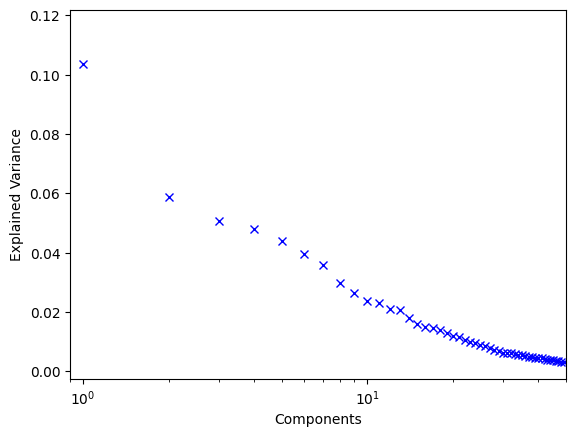

In [38]:

chain='TRA'
v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
vdjdb_v = pd.read_csv(v_path,sep='\t')


tcremb_100_a = TCRemb.TCRemb(run_name, vdjdb_v)
tcremb_100_a.tcremb_clonotypes(chain)
#tcremb_100_a.tcremb_dists_count(chain)
tcremb_100_a.tcremb_dists(chain)
tcremb_100_a.tcremb_pca(chain)
tcremb_100_a.tcremb_tsne(chain)


dbscan_100 = TCRemb.TCRemb_clustering('DBSCAN')

model = DBSCAN(eps=750, min_samples=2)
dbscan_100.clstr(chain,tcremb_100_a, label, model=model)

res_clstr_100[chain] = tcremb_100_a.annot[chain][[tcremb_100_a.annotation_id,label]].merge(dbscan_100.clstr_labels[chain],how='left')
metrics_100[chain] = metrics.get_clustermetrics(res_clstr_100[chain], label)

print(metrics_100[chain])

{'TRA': 'data/data_preped/olga_humanTRA.txt', 'TRB': 'data/data_preped/olga_humanTRB.txt'}
[κ0 CASSAFPCREGRNNEQFF, κ1 CASSHGVGQGPYEQYF, κ2 CASSLTTESGEQYF, κ3 CASSLGTLEETQYF, κ4 CASIPEGGRETQYF, κ5 CASSLDSLNTIYF, κ6 CASSQDTASSYEQYF, κ7 CASSLSYRGNSPLHF, κ8 CASSEALRDSGGQYF, κ9 CSADGLPISSYNEQFF]
(21725, 9001)
909.2553215026855


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


purity:0.8989534464092386
{'purity': 0.8989534464092386, 'retention': 0.1257373627370905, 'consistency': 0.0012789606640202097, 'ami': 0.8514917000602702, 'accuracy': 0.0039553602091882975, 'precision': 0.8901783734434399, 'recall': 0.8989534464092395, 'f1-score': 0.8945443905769266, 'support': 2771, 'mean_clustsize': 3.2183507549361208}


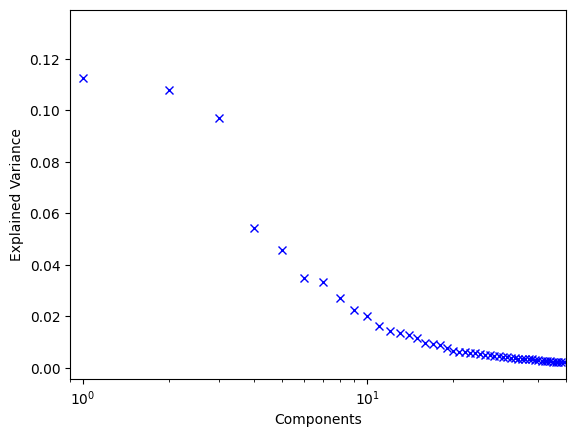

In [13]:

chain='TRB'
v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
vdjdb_v = pd.read_csv(v_path,sep='\t')


tcremb_100_b = TCRemb.TCRemb(run_name, vdjdb_v)
tcremb_100_b.tcremb_clonotypes(chain)
tcremb_100_b.tcremb_dists_count(chain)
tcremb_100_b.tcremb_dists(chain)
tcremb_100_b.tcremb_pca(chain)
tcremb_100_b.tcremb_tsne(chain)


dbscan_100 = TCRemb.TCRemb_clustering('DBSCAN')

model = DBSCAN(eps=750, min_samples=2)
dbscan_100.clstr(chain,tcremb_100_b, label, model=model)

res_clstr_100[chain] = tcremb_100_b.annot[chain][[tcremb_100_b.annotation_id,label]].merge(dbscan_100.clstr_labels[chain],how='left')
metrics_100[chain] = metrics.get_clustermetrics(res_clstr_100[chain], label)

print(metrics_100[chain])

In [14]:
## 100 prototypes
i = 10
j = 3000
metrics_3000={}
res_clstr_3000={}
run_name = f'compare_V{i}_{j}'
proto_path_dict = {'TRA' :f'data/data_preped/olga_humanTRA_{j}.txt', 'TRB' : f'data/data_preped/olga_humanTRB_{j}.txt'}

In [ ]:
for i in samples_n:
    for j in prototypes_n:
        run_name = f'compare_V{i}_{j}'
        proto_path_dict = {'TRA' :f'data/data_preped/olga_humanTRA_{j}.txt', 'TRB' : f'data/data_preped/olga_humanTRB_{j}.txt'}
    
        chain='TRA'
        v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
        run_tcremb_v(chain, run_name, v_path, proto_path_dict)
        chain='TRB'
        v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
        run_tcremb_v(chain, run_name, v_path, proto_path_dict)

In [ ]:
def run_tcremb_v(chain, run_name, v_path, proto_path):
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    tcremb = TCRemb.TCRemb(run_name, vdjdb_v,prototypes_path=proto_path_dict)
    tcremb.tcremb_clonotypes(chain)
    tcremb.tcremb_dists_count(chain)
    tcremb.tcremb_dists(chain)
    

{'TRA': 'data/data_preped/olga_humanTRA.txt', 'TRB': 'data/data_preped/olga_humanTRB.txt'}
[κ0 CASNTGTASKLTF, κ1 CAVLLEYGNKLVF, κ2 CVVSAIMDSNYQLIW, κ3 CLVGATTDSWGKLQF, κ4 CLVGPLSGGYNKLIF, κ5 CAGAVGNQFYF, κ6 CAVNDNDKIIF, κ7 CALSDPTSGGYQKVTF, κ8 CAEAEGGGSQGNLIF, κ9 CAVRATGTASKLTF]
(10153, 8854)
374.2479314804077


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


purity:0.8021927820922796
{'purity': 0.8021927820922796, 'retention': 0.2116816555458853, 'consistency': 0.002078252980652301, 'ami': 0.6719512787218926, 'accuracy': 0.0018239793176606067, 'precision': 0.8017593083653567, 'recall': 0.80219278209228, 'f1-score': 0.8019759866549142, 'support': 2189, 'mean_clustsize': 3.1863173216885006}


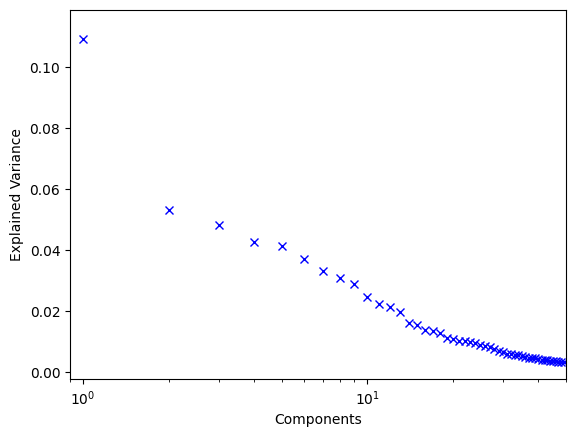

In [15]:

chain='TRA'
v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
vdjdb_v = pd.read_csv(v_path,sep='\t')


tcremb_3000_a = TCRemb.TCRemb(run_name, vdjdb_v)
tcremb_3000_a.tcremb_clonotypes(chain)
tcremb_3000_a.tcremb_dists_count(chain)
tcremb_3000_a.tcremb_dists(chain)
tcremb_3000_a.tcremb_pca(chain)
tcremb_3000_a.tcremb_tsne(chain)


dbscan_3000 = TCRemb.TCRemb_clustering('DBSCAN')

model = DBSCAN(eps=750, min_samples=2)
dbscan_3000.clstr(chain,tcremb_3000_a, label, model=model)

res_clstr_3000[chain] = tcremb_3000_a.annot[chain][[tcremb_3000_a.annotation_id,label]].merge(dbscan_3000.clstr_labels[chain],how='left')
metrics_3000[chain] = metrics.get_clustermetrics(res_clstr_3000[chain], label)

print(metrics_3000[chain])



{'TRA': 'data/data_preped/olga_humanTRA.txt', 'TRB': 'data/data_preped/olga_humanTRB.txt'}
[κ0 CASSAFPCREGRNNEQFF, κ1 CASSHGVGQGPYEQYF, κ2 CASSLTTESGEQYF, κ3 CASSLGTLEETQYF, κ4 CASIPEGGRETQYF, κ5 CASSLDSLNTIYF, κ6 CASSQDTASSYEQYF, κ7 CASSLSYRGNSPLHF, κ8 CASSEALRDSGGQYF, κ9 CSADGLPISSYNEQFF]
(21725, 9001)
931.0923249721527


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


purity:0.8985925658607001
{'purity': 0.8985925658607001, 'retention': 0.1257373627370905, 'consistency': 0.0012789606640202097, 'ami': 0.851723516623338, 'accuracy': 0.0039553602091882975, 'precision': 0.8932017180212988, 'recall': 0.8985925658607011, 'f1-score': 0.8958890324050199, 'support': 2771, 'mean_clustsize': 3.21461716937355}


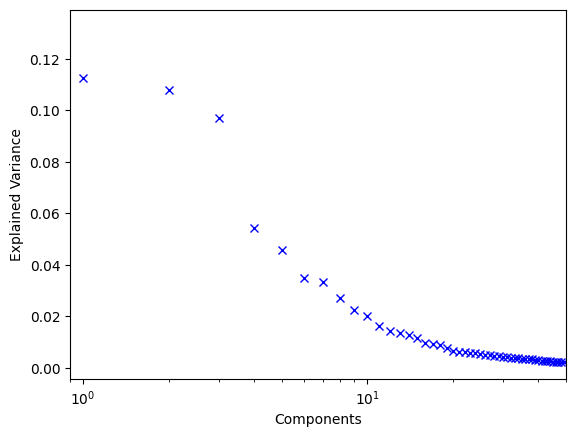

In [16]:

chain='TRB'
v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
vdjdb_v = pd.read_csv(v_path,sep='\t')


tcremb_3000_b = TCRemb.TCRemb(run_name, vdjdb_v)
tcremb_3000_b.tcremb_clonotypes(chain)
tcremb_3000_b.tcremb_dists_count(chain)
tcremb_3000_b.tcremb_dists(chain)
tcremb_3000_b.tcremb_pca(chain)
tcremb_3000_b.tcremb_tsne(chain)


dbscan_3000 = TCRemb.TCRemb_clustering('DBSCAN')

model = DBSCAN(eps=750, min_samples=2)
dbscan_3000.clstr(chain,tcremb_3000_b, label, model=model)

res_clstr_3000[chain] = tcremb_3000_b.annot[chain][[tcremb_3000_b.annotation_id,label]].merge(dbscan_3000.clstr_labels[chain],how='left')
metrics_3000[chain] = metrics.get_clustermetrics(res_clstr_3000[chain], label)

print(metrics_3000[chain])

In [5]:
metrics_tcremb={}
samples_n=[10]
prototypes_n=[3000]

In [6]:
method = 'dbscan'
#params=[3, 10,25, 50,75, 100,150,200,250,300,350,400,450, 500,550, 600,650, 700,750, 800,850, 900,950, 1000, 1050,1100,1150, 1200,1250, 1300,1350, 1400,1450, 1500]
params=[750]
metrics_tcremb[method]={}

/scratch/ipykernel_1481972/971745361.py:11: DtypeWarning: Columns (20,22,24,25,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  vdjdb_v = pd.read_csv(v_path,sep='\t')


TCR-epitope paires count in V10 dataset: 34273
data/data_preped/VDJdb_data_V10.csv


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


purity:0.9891640866873065


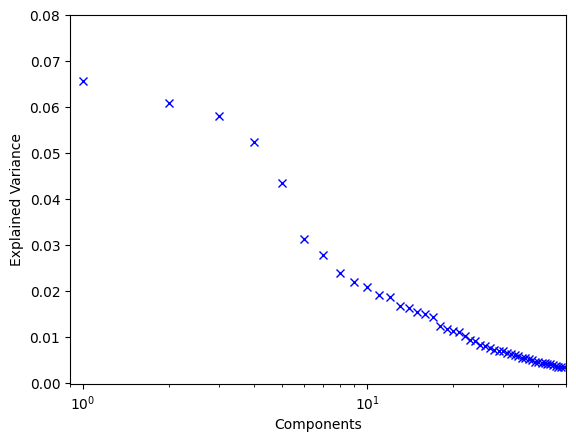

In [7]:
chain = 'TRA_TRB'
metrics_tcremb[method][chain]={}
for n_prototypes in prototypes_n:
    for i in samples_n:
        #if n_prototypes==3000:
        #    run_name = f'compare_V{i}'
        #else:
        #    run_name = f'compare_V{i}_{n_prototypes}'
        run_name = f'compare_V{i}_{n_prototypes}'
        v_path = f'data/data_preped/VDJdb_data_V{i}.csv'
        vdjdb_v = pd.read_csv(v_path,sep='\t')
        print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
        print(v_path)
    
        tcremb = TCRemb.TCRemb(run_name, vdjdb_v)
        tcremb.tcremb_clonotypes(chain)
        tcremb.tcremb_dists(chain)
        tcremb.tcremb_pca(chain)
        tcremb.tcremb_tsne(chain)
        
        data_len = len(tcremb.pca_clones[chain])
        
        for j in params:
            dbscan = TCRemb.TCRemb_clustering(method)
            model = DBSCAN(eps=j, min_samples=2)
            dbscan.clstr(chain,tcremb, label, model=model)
            t = tcremb.annot[chain][[tcremb.annotation_id,label]].merge(dbscan.clstr_labels[chain],how='left')
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}'] = metrics.get_clustermetrics(t, label)
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}']['n_prototypes']=n_prototypes
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}']['eps']=j
            metrics_tcremb[method][chain][f'V{i}_P{n_prototypes}_e{j}']['v']=f'V{i}_TCRs_count:{len(tcremb.pca_clones[chain])}'

In [12]:
t[(t['is_cluster']==1)&(t['antigen.epitope']!=t['label_cluster'])]

annotId antigen.epitope  cluster   label_cluster  total_cluster  \
67         67   PKYVKQNTLKLAT        2       GILGFVFTL             27   
1068     1068       CINGVCWTV        8       GLCTLVAML             16   
2281     2281       GILGFVFTL       19       NLVPMVATV              3   
2351     2351       GILGFVFTL        4       NLVPMVATV              3   
2812     2812       LTDEMIAQY      103  TFEYVSQPFLMDLE              3   
2967     2967       NQKLIANQF       13       RPPIFIRRL              3   
3465     3465       LLWNGPMAV      114      AVFDRKSDAK              6   

      total_group  count_matched  fraction_matched  fraction_matched_exp  \
67            805             26          0.962963              0.159596   
1068          212             15          0.937500              0.042030   
2281          476              2          0.666667              0.094370   
2351          476              2          0.666667              0.094370   
2812          401              2          0.666667              0.079500   
2967           32              2          0.666667              0.006344   
3465            9              5          0.833333              0.001784   

           p_value  is_cluster  enriched_clstr         a_cdr3aa     TRAV  \
67    4.339472e-20           1               1     CAGAGSQGNLIF   TRAV27   
1068  3.467950e-20           1               1      CAEDNNARLMF    TRAV5   
2281  2.503600e-02           1               0   CAGPMKTSYDKVIF   TRAV35   
2351  2.503600e-02           1               0      CARNTGNQFYF   TRAV24   
2812  1.795600e-02           1               0  CAGLNYGGSQGNLIF   TRAV35   
2967  1.202348e-04           1               0    CAFASSNTGKLIF   TRAV24   
3465  1.083533e-13           1               1     CAVGDNFNKFYF  TRAV8-3   

        TRAJ          b_cdr3aa      TRBV     TRBJ  
67    TRAJ42     CASSSRSSYEQYF    TRBV19  TRBJ2-7  
1068  TRAJ31     CSARDATGNGYTF  TRBV20-1  TRBJ1-2  
2281  TRAJ50      CASSSANYGYTF  TRBV12-4  TRBJ1-2  
2351  TRAJ49  CASSKQTGTGNYGYTF   TRBV6-5  TRBJ1-2  
2812  TRAJ42  CASSPRDRVNTGELFF     TRBV9  TRBJ2-2  
2967  TRAJ37    CASSQDRVTGKYTF   TRBV4-1  TRBJ1-2  
3465  TRAJ21    CASSLSSATGELFF    TRBV28  TRBJ2-2